In [1]:
# importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
import ast
from itertools import combinations, product
import joypy

from lemmatizer import nltk_tag_to_wordnet_tag,lemmatize_tweet, tweet_cleaner

from time import time
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import multiprocessing
from wordcloud import WordCloud
from transformers import DistilBertTokenizer, DistilBertModel
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,root_mean_squared_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import faiss

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shyam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\shyam\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shyam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shyam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\shyam\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
c:\Users\shyam\anaconda3\envs\dw_nominate\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: 

In [2]:
current_directory = os.getcwd()
print(current_directory)

c:\Users\shyam\Regression Modelling with LLM of political ideology\dw-nominate-scores


In [3]:
# loading the training data 
training_data = pd.read_csv("training_data.csv")
training_data

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate
0,8,b'WATCH my speech on the @SenateFloor to learn...,PatientFreedomAct,3,2017,0.243962,0.170366
1,2,b'Boehner delays leadership races. Only speake...,rossformajoritywhip,3,2015,0.561728,0.089540
2,5,"b""I'll be sharing #scarynumbers about #governm...",scarynumbers governmentspending,4,2014,0.513246,-0.224541
3,34,"b""#OTD in '64, LBJ took important step towards...",OTD,14,2017,-0.241932,0.097843
4,23,b'My bipartisan bill is a step toward protecti...,VA07,7,2020,-0.225722,0.329999
...,...,...,...,...,...,...,...
333982,97,"b""I am working to make Social Security stronge...",ExpandSocialSecurity,29,2018,-0.423522,0.005929
333983,11,b'Climate change -&gt; altered CA forest ecosy...,actonclimate,11,2016,-0.436272,-0.546745
333984,82,b'The @USChamber and other business lobbying g...,climate,34,2019,-0.309244,-0.070852
333985,1,b'I look forward to answering constituent\xe2\...,TeleTownHall,1,2016,-0.516671,0.205851


In [4]:
# creating a new dataframe (for further processing) to retain the originally loaded data in "training_data" in case required later
training_df = pd.DataFrame(data=training_data)

In [5]:
# viewing the full_text attribute 
training_df["full_text"].to_list()

["b'WATCH my speech on the @SenateFloor to learn more about the #PatientFreedomAct and what it means for West Virginia. https://t.co/MXV9dHZOTe'",
 "b'Boehner delays leadership races. Only speaker election this week. #rossformajoritywhip'",
 'b"I\'ll be sharing #scarynumbers about #governmentspending for the rest of the month. Keep an eye out for the stats, here."',
 'b"#OTD in \'64, LBJ took important step towards fulfilling promise of the Constitution by signing the Civil Rights Act. https://t.co/UmYmWV8p7A"',
 "b'My bipartisan bill is a step toward protecting &amp; expanding affordable, reliable healthcare access as the pandemic continues. Telehealth is a vital part of that effort. Through expanded access to telehealth, we can reduce costs and improve health outcomes. #VA07 https://t.co/1gre1lOtgM'",
 "b'This misguided decision threatens to rip health care away from millions of hardworking families. The courts will overturn, and Congress must get to work securing quality, affordable

In [6]:
# function to decode the byte string (punctuations, emojis, etc will be decoded from hexadecimal codes) 
def byte_string_decode(tweet):
    b_string = ast.literal_eval(tweet)
    return b_string.decode('utf-8')

In [7]:
# decoding the byte string into string from the "full_text" column
training_df["full_text"] = training_df["full_text"].apply(byte_string_decode)
training_df["full_text"].to_list()

['WATCH my speech on the @SenateFloor to learn more about the #PatientFreedomAct and what it means for West Virginia. https://t.co/MXV9dHZOTe',
 'Boehner delays leadership races. Only speaker election this week. #rossformajoritywhip',
 "I'll be sharing #scarynumbers about #governmentspending for the rest of the month. Keep an eye out for the stats, here.",
 "#OTD in '64, LBJ took important step towards fulfilling promise of the Constitution by signing the Civil Rights Act. https://t.co/UmYmWV8p7A",
 'My bipartisan bill is a step toward protecting &amp; expanding affordable, reliable healthcare access as the pandemic continues. Telehealth is a vital part of that effort. Through expanded access to telehealth, we can reduce costs and improve health outcomes. #VA07 https://t.co/1gre1lOtgM',
 'This misguided decision threatens to rip health care away from millions of hardworking families. The courts will overturn, and Congress must get to work securing quality, affordable health care for al

Section A
Part a)

In [8]:
# fetching the character and word lengths of "full_text" column
training_df['text_char_len'] = training_df['full_text'].apply(lambda x: len(x))

for i in range(len(training_df)):
    words = training_df.loc[i, 'full_text'].split()

    training_df.loc[i, 'text_word_len'] = len(words)
    
training_df[['text_char_len','text_word_len']]

,text_char_len,text_word_len
0,139,20.0
1,86,10.0
2,119,20.0
3,140,20.0
4,289,41.0
...,...,...
333982,179,26.0
333983,142,18.0
333984,190,28.0
333985,138,18.0


In [9]:
# fetching the character and word lengths of "hashtags" column
training_df['hash_char_len'] = training_df['hashtags'].apply(lambda x: len(''.join(x.split()))) # to not count any trailing spaces
training_df['hash_word_len'] = training_df['hashtags'].apply(lambda x: len(x.split())) # counting words under pretext of separation by spaces
training_df[['hash_char_len','hash_word_len']]

,hash_char_len,hash_word_len
0,17,1
1,19,1
2,30,2
3,3,1
4,4,1
...,...,...
333982,20,1
333983,12,1
333984,7,1
333985,12,1


In [10]:
# storing the summary statistics in a dictionary to be later converted to a table

stats = {
    'text' : {
        'char' : {
                'mini' : training_df['text_char_len'].min(),
                'avg' : training_df['text_char_len'].mean(),
                'med' : training_df['text_char_len'].median(),
                'maxi' : training_df['text_char_len'].max()
        },
        'word' : {
                'mini' : training_df['text_word_len'].min(),
                'avg' : training_df['text_word_len'].mean(),
                'med' : training_df['text_word_len'].median(),
                'maxi' : training_df['text_word_len'].max()
        }
    },
    'hashtag' : {
        'char' : {
                'mini' : training_df['hash_char_len'].min(),
                'avg' : training_df['hash_char_len'].mean(),
                'med' : training_df['hash_char_len'].median(),
                'maxi' : training_df['hash_char_len'].max()
        },
        'word' : {
                'mini' : training_df['hash_word_len'].min(),
                'avg' : training_df['hash_word_len'].mean(),
                'med' : training_df['hash_word_len'].median(),
                'maxi' : training_df['hash_word_len'].max()
        }
    }
}

stats

{'text': {'char': {'mini': np.int64(4),
   'avg': np.float64(173.82392727860665),
   'med': np.float64(143.0),
   'maxi': np.int64(531)},
  'word': {'mini': np.float64(1.0),
   'avg': np.float64(25.03559120564573),
   'med': np.float64(21.0),
   'maxi': np.float64(67.0)}},
 'hashtag': {'char': {'mini': np.int64(1),
   'avg': np.float64(14.044142436681668),
   'med': np.float64(12.0),
   'maxi': np.int64(168)},
  'word': {'mini': np.int64(1),
   'avg': np.float64(1.4919802267752937),
   'med': np.float64(1.0),
   'maxi': np.int64(17)}}}

In [11]:
# storing the summary stats from a dictionary to a dataframe
stats_table = pd.DataFrame(columns = ["#char_text", "#word_text","#char_hashtag","#word_hashtag"], index =["Min","Avg","Med","Max"])

for metric, content in stats.items():
    for length_type, value in content.items():
        for stat, magnitude in value.items():
            index_map = {
                'mini' : 'Min',
                'avg' :'Avg',
                'med' : 'Med',
                'maxi' : 'Max'
            }
            column = f"#{length_type}_{metric}"
            index = index_map[stat]
            
            stats_table.loc[index,column] = magnitude
            
stats_table


,#char_text,#word_text,#char_hashtag,#word_hashtag
Min,4,1.0,1,1
Avg,173.823927,25.035591,14.044142,1.49198
Med,143.0,21.0,12.0,1.0
Max,531,67.0,168,17


Section A Part b)

In [12]:
# finding the top ten most commonly used hashtags
hashtags = {}

for i in range(len(training_df)):
    tags = training_df.loc[i, 'hashtags'].split()
    for tag in tags:
        hashtags[tag] = hashtags.get(tag, 1) + 1

sorted_hashtags_desc = dict(sorted(hashtags.items(), key=lambda item: item[1], reverse=True))

top_10_hashtags = list(sorted_hashtags_desc.keys())[0:10]

top_10_hashtags

['COVID19',
 'tcot',
 'SOTU',
 'Obamacare',
 'utpol',
 'coronavirus',
 'ForThePeople',
 'ACA',
 'ProtectOurCare',
 '4jobs']

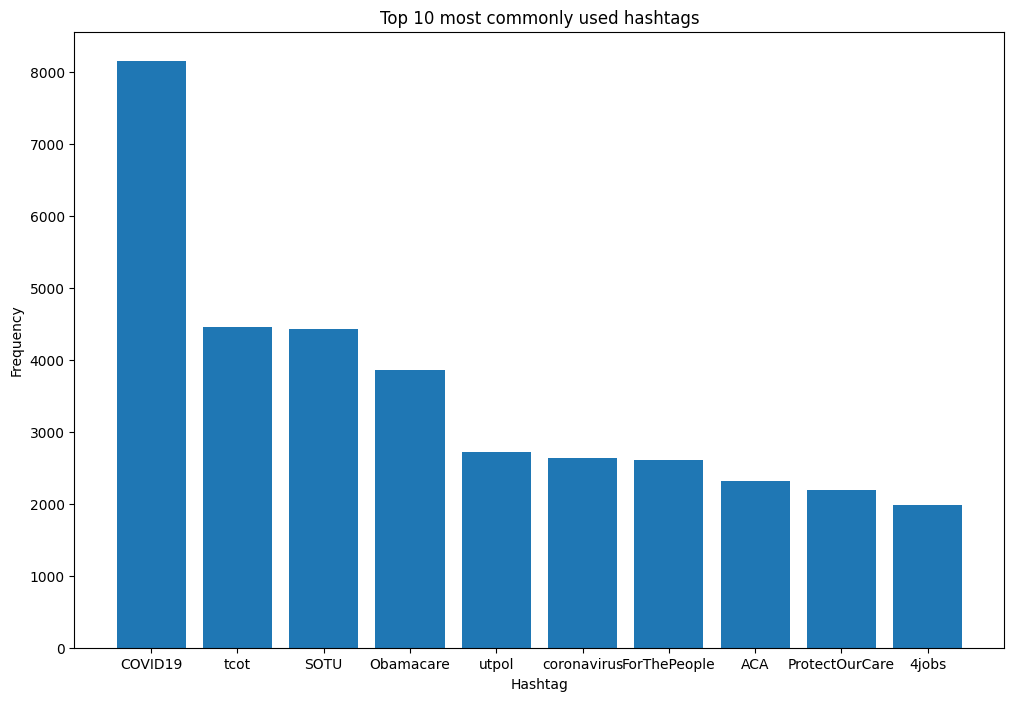

In [13]:
# plotting the count values of the ten most commonly used hashtags
plt.figure(figsize = (12,8))
plt.bar(top_10_hashtags, list(sorted_hashtags_desc.values())[0:10])
plt.xlabel('Hashtag')
plt.ylabel('Frequency')
plt.title('Top 10 most commonly used hashtags')
plt.show()

Section A Part c)

In [14]:
# dividing the training dataset into 4 subsets by given thresholds

training_df_group_1 = training_df[(training_df['dim1_nominate'] > 0) & (training_df['dim2_nominate'] > 0)].reset_index()
training_df_group_2 = training_df[(training_df['dim1_nominate'] > 0) & (training_df['dim2_nominate'] < 0)].reset_index()
training_df_group_3 = training_df[(training_df['dim1_nominate'] < 0) & (training_df['dim2_nominate'] > 0)].reset_index()
training_df_group_4 = training_df[(training_df['dim1_nominate'] < 0) & (training_df['dim2_nominate'] < 0)].reset_index()

In [15]:
# finding the top 10 topics for group 1
hashtags_group_1 = {}

for i in range(len(training_df_group_1)):
    tags = training_df_group_1.loc[i, 'hashtags'].split()
    for tag in tags:
        hashtags_group_1[tag] = hashtags_group_1.get(tag, 1) + 1

sorted_hashtags_group_1_desc = dict(sorted(hashtags_group_1.items(), key=lambda item: item[1], reverse=True))

top_10_hashtags_group_1 = list(sorted_hashtags_group_1_desc.keys())[0:10]

top_10_hashtags_group_1

['tcot',
 'Obamacare',
 'COVID19',
 'SOTU',
 'TaxReform',
 'utpol',
 'AR3',
 'taxreform',
 '4jobs',
 'USMCA']

In [16]:
# finding the top 10 topics for group 2
hashtags_group_2 = {}

for i in range(len(training_df_group_2)):
    tags = training_df_group_2.loc[i, 'hashtags'].split()
    for tag in tags:
        hashtags_group_2[tag] = hashtags_group_2.get(tag, 1) + 1

sorted_hashtags_group_2_desc = dict(sorted(hashtags_group_2.items(), key=lambda item: item[1], reverse=True))

top_10_hashtags_group_2 = list(sorted_hashtags_group_2_desc.keys())[0:10]

top_10_hashtags_group_2

['IA03',
 'Obamacare',
 'tcot',
 'NY22',
 'COVID19',
 'SouthJersey',
 '4jobs',
 'SOTU',
 'NY24',
 'VA05']

In [17]:
# finding the top 10 topics for group 3
hashtags_group_3 = {}

for i in range(len(training_df_group_3)):
    tags = training_df_group_3.loc[i, 'hashtags'].split()
    for tag in tags:
        hashtags_group_3[tag] = hashtags_group_3.get(tag, 1) + 1

sorted_hashtags_group_3_desc = dict(sorted(hashtags_group_3.items(), key=lambda item: item[1], reverse=True))

top_10_hashtags_group_3 = list(sorted_hashtags_group_3_desc.keys())[0:10]

top_10_hashtags_group_3

['COVID19',
 'utpol',
 'mtpol',
 'ForThePeople',
 'VA07',
 'ProtectOurCare',
 'ACA',
 'FL07',
 'coronavirus',
 'FlaPol']

In [18]:
# finding the top 10 topics for group 4
hashtags_group_4 = {}

for i in range(len(training_df_group_4)):
    tags = training_df_group_4.loc[i, 'hashtags'].split()
    for tag in tags:
        hashtags_group_4[tag] = hashtags_group_4.get(tag, 1) + 1

sorted_hashtags_group_4_desc = dict(sorted(hashtags_group_4.items(), key=lambda item: item[1], reverse=True))

top_10_hashtags_group_4 = list(sorted_hashtags_group_4_desc.keys())[0:10]

top_10_hashtags_group_4

['COVID19',
 'GOPTaxScam',
 'ForThePeople',
 'ACA',
 'ProtectOurCare',
 'SOTU',
 'NetNeutrality',
 'Trumpcare',
 'DACA',
 'ActOnClimate']

C:\Users\shyam\AppData\Local\Temp\ipykernel_370420\407157574.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,0].set_xticklabels(top_10_hashtags_group_1, rotation=45)
C:\Users\shyam\AppData\Local\Temp\ipykernel_370420\407157574.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0,1].set_xticklabels(top_10_hashtags_group_2, rotation=45)
C:\Users\shyam\AppData\Local\Temp\ipykernel_370420\407157574.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,0].set_xticklabels(top_10_hashtags_group_3, rotation=45)
C:\Users\shyam\AppData\Local\Temp\ipykernel_370420\407157574.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,1].set_xtickla

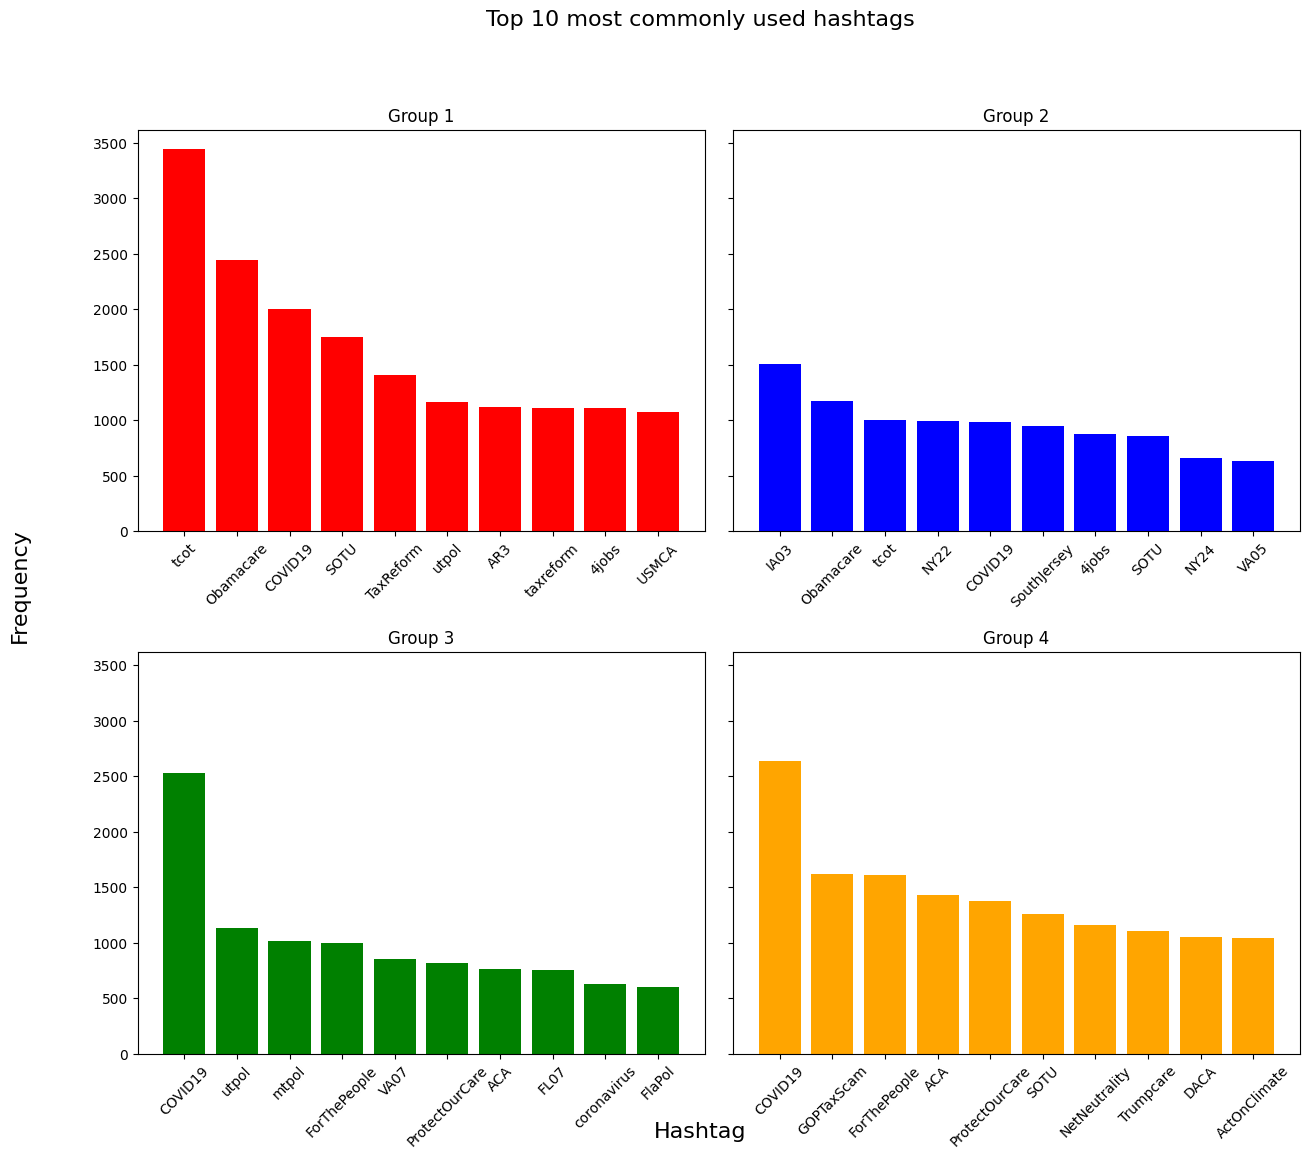

In [19]:
# plotting the bar charts for all 4 groups 
fig, axs = plt.subplots(2, 2, sharey = True, figsize=(15,12))

axs[0,0].bar(top_10_hashtags_group_1, list(sorted_hashtags_group_1_desc.values())[0:10], color='red') 
axs[0,0].set_title('Group 1')
axs[0,0].set_xticklabels(top_10_hashtags_group_1, rotation=45)

axs[0,1].bar(top_10_hashtags_group_2, list(sorted_hashtags_group_2_desc.values())[0:10], color='blue') 
axs[0,1].set_title('Group 2')
axs[0,1].set_xticklabels(top_10_hashtags_group_2, rotation=45)

axs[1,0].bar(top_10_hashtags_group_3, list(sorted_hashtags_group_3_desc.values())[0:10], color='green') 
axs[1,0].set_title('Group 3')
axs[1,0].set_xticklabels(top_10_hashtags_group_3, rotation=45)

axs[1,1].bar(top_10_hashtags_group_4, list(sorted_hashtags_group_4_desc.values())[0:10], color='orange') 
axs[1,1].set_title('Group 4')
axs[1,1].set_xticklabels(top_10_hashtags_group_4, rotation=45)

fig.text(0.5, 0.04, 'Hashtag', ha='center', fontsize=16)
fig.text(0.04, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=16)
fig.suptitle('Top 10 most commonly used hashtags', fontsize=16)

plt.tight_layout(rect=[0.2,0.5,0.3,0.7])
plt.subplots_adjust(wspace=0.05, hspace=0.3)

Section A Part d)

c:\Users\shyam\anaconda3\envs\dw_nominate\Lib\site-packages\joypy\joyplot.py:238: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


<Figure size 1000x800 with 0 Axes>

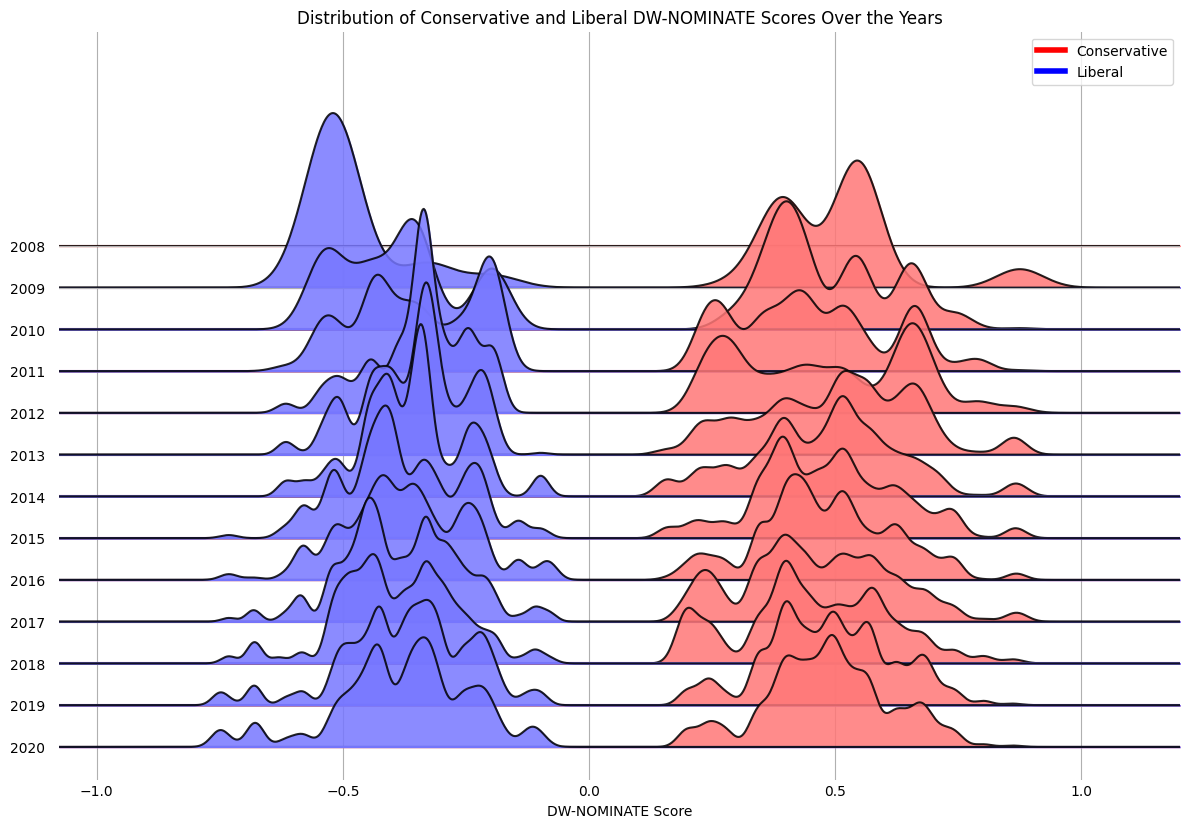

In [20]:
# Dividing the data for ridge plot and plotting it 

df = training_df[['dim1_nominate', 'year']].copy()
df = df.sort_values(by='year')

# New DataFrame to store balanced data
df_balanced = pd.DataFrame()

for year in df['year'].unique():
    df_year = df[df['year'] == year]
    conservative = df_year[df_year['dim1_nominate'] > 0]['dim1_nominate']
    liberal = df_year[df_year['dim1_nominate'] <= 0]['dim1_nominate']
    
    # Balance the number of rows between conservative and liberal by adding NaNs
    if len(conservative) > len(liberal):
        nans_to_add = pd.Series([np.nan] * (len(conservative) - len(liberal)))
        liberal = pd.concat([liberal, nans_to_add], ignore_index=True)
    else:
        nans_to_add = pd.Series([np.nan] * (len(liberal) - len(conservative)))
        conservative = pd.concat([conservative, nans_to_add], ignore_index=True)
    
    # Creating a temporary DataFrame for each year
    max_length = max(len(conservative), len(liberal))
    df_temp = pd.DataFrame({
        'year': [year] * max_length,
        'Conservative': conservative.values,
        'Liberal': liberal.values
    })
    
    df_balanced = pd.concat([df_balanced, df_temp], ignore_index=True)

# Plotting
plt.figure(figsize=(10, 8))

# Joypy requires long-form data, and the categories are given by 'by', and columns to plot are automatically taken as numerical columns
fig, axes = joypy.joyplot(
    data=df_balanced,
    by='year',
    figsize=(12, 8),
    overlap=3,
    grid=True, 
    fill=True,
    linecolor='black',
    color=['#ff7777', '#7777ff'],  # Custom colors: light red for Conservative, light blue for Liberal
    alpha=0.85
)

plt.xlabel('DW-NOMINATE Score')
plt.title('Distribution of Conservative and Liberal DW-NOMINATE Scores Over the Years')
plt.legend(handles=[
    plt.Line2D([0], [0], color='red', lw=4, label='Conservative'),
    plt.Line2D([0], [0], color='blue', lw=4, label='Liberal')
], loc='upper right')
plt.show()


Section A Part e)a.

In [21]:
# top 10 most distant tweets along both dimensions
# Extract the two dimensions (dim1_nominate and dim2_nominate) and drop duplicates
dim_cols = training_df[['dim1_nominate', 'dim2_nominate']].drop_duplicates().to_numpy()

# Function to calculate Euclidean distance between two points in 2D
def calculate_distance_both_dims(i, j):
    point1 = dim_cols[i]
    point2 = dim_cols[j]
    dist = np.sqrt(np.sum((point1 - point2) ** 2))  # Euclidean distance in 2D
    return (i, j, dist)

# Function to find the single most distant pair of points
def get_most_distant_pair():
    most_distant_pair = None

    # Iterate over all unique pairs of points (i, j) using combinations
    for i, j in combinations(range(len(dim_cols)), 2):
        i, j, dist = calculate_distance_both_dims(i, j)
        
        # Check if we found a new most distant pair
        if most_distant_pair is None or dist > most_distant_pair[2]:
            most_distant_pair = (i, j, dist)

    # Return the most distant pair of points and their distance
    return most_distant_pair

# Get the most distant pair of points along both dimensions
most_distant_pair = get_most_distant_pair()

# Extract the actual values of the most distant points
point1_values = dim_cols[most_distant_pair[0]]
point2_values = dim_cols[most_distant_pair[1]]

# Find all rows in the original dataframe where dim1 and dim2 match the most distant pair
df_matching_point1 = training_df[(training_df['dim1_nominate'] == point1_values[0]) & (training_df['dim2_nominate'] == point1_values[1])]
df_matching_point2 = training_df[(training_df['dim1_nominate'] == point2_values[0]) & (training_df['dim2_nominate'] == point2_values[1])]

# Get the first 10 pairs of tweets
tweet_pairs_data = []

# Use itertools.product to find all possible combinations between the two dataframes
pairs = list(product(df_matching_point1['full_text'].head(10), df_matching_point2['full_text'].head(10)))

# Store the first 10 pairs of tweets and their distance
for tweet1, tweet2 in pairs[:10]:
    tweet_pairs_data.append((tweet1, tweet2, most_distant_pair[2]))

# Convert the tweet pairs and distances to a DataFrame
df_tweet_pairs = pd.DataFrame(tweet_pairs_data, columns=['Tweet1', 'Tweet2', 'Distance'])

pd.set_option('display.max_colwidth', None)

df_tweet_pairs['Tweet1'] = df_tweet_pairs['Tweet1'].apply(lambda x: '\n'.join([x[i:i+50] for i in range(0, len(x), 50)]))
df_tweet_pairs['Tweet2'] = df_tweet_pairs['Tweet2'].apply(lambda x: '\n'.join([x[i:i+50] for i in range(0, len(x), 50)]))
df_tweet_pairs

,Tweet1,Tweet2,Distance
0,This weekly roundup: I voted to pass Con. Castro’s\n resolution 2 block Trump's #FakeEmergency declara\ntion &amp; the 1st major gun safety legislation in\n over 25 years. My colleagues and I on @HouseJudic\niary also investigated the admin’s harmful separat\nion policy at the border.#TX29 https://t.co/xUTwAf\nVG1i,"In the wake of #ebola, continued economic progress\n is key for #Liberia. Watch live as I speak to @CG\nDev at 9:30am ET https://t.co/sXDuRhMN6O",1.927598
1,This weekly roundup: I voted to pass Con. Castro’s\n resolution 2 block Trump's #FakeEmergency declara\ntion &amp; the 1st major gun safety legislation in\n over 25 years. My colleagues and I on @HouseJudic\niary also investigated the admin’s harmful separat\nion policy at the border.#TX29 https://t.co/xUTwAf\nVG1i,"Congrats to my alma mater, Snowflake Jr. HS, for s\nelection as a '17 #SamsungSolve STEAM finalist. #S\namsungSolveSJHS https://t.co/RSXZwny23l",1.927598
2,This weekly roundup: I voted to pass Con. Castro’s\n resolution 2 block Trump's #FakeEmergency declara\ntion &amp; the 1st major gun safety legislation in\n over 25 years. My colleagues and I on @HouseJudic\niary also investigated the admin’s harmful separat\nion policy at the border.#TX29 https://t.co/xUTwAf\nVG1i,Just got my copy of the #healthcare bill and I'm g\noing to take time to thoroughly read and review it,1.927598
3,This weekly roundup: I voted to pass Con. Castro’s\n resolution 2 block Trump's #FakeEmergency declara\ntion &amp; the 1st major gun safety legislation in\n over 25 years. My colleagues and I on @HouseJudic\niary also investigated the admin’s harmful separat\nion policy at the border.#TX29 https://t.co/xUTwAf\nVG1i,".@FoxNews @SpecialReport on my effort w @dougducey\n &amp; @SenJohnMcCain to get #AZ out of the oversi\nzed, overworked &amp; oft-overturned #9thCircuit h\nttps://t.co/TtdteiTNmP",1.927598
4,This weekly roundup: I voted to pass Con. Castro’s\n resolution 2 block Trump's #FakeEmergency declara\ntion &amp; the 1st major gun safety legislation in\n over 25 years. My colleagues and I on @HouseJudic\niary also investigated the admin’s harmful separat\nion policy at the border.#TX29 https://t.co/xUTwAf\nVG1i,Cheryl bags trash @justserve project at Salt River\n this morning. LDS and other faiths team up to ser\nve. #justserve https://t.co/rpU1Crk3gN,1.927598
5,This weekly roundup: I voted to pass Con. Castro’s\n resolution 2 block Trump's #FakeEmergency declara\ntion &amp; the 1st major gun safety legislation in\n over 25 years. My colleagues and I on @HouseJudic\niary also investigated the admin’s harmful separat\nion policy at the border.#TX29 https://t.co/xUTwAf\nVG1i,"It's my Earth, Wind &amp; Fire week so #LetsGroove\n w 3 more bills to make rural AZ a #ShiningStar of\n growth &amp; investment https://t.co/LQq76qrcIY",1.927598
6,This weekly roundup: I voted to pass Con. Castro’s\n resolution 2 block Trump's #FakeEmergency declara\ntion &amp; the 1st major gun safety legislation in\n over 25 years. My colleagues and I on @HouseJudic\niary also investigated the admin’s harmful separat\nion policy at the border.#TX29 https://t.co/xUTwAf\nVG1i,#Wastebook sparking lots of great convo but none m\nore entertaining than this @oreillyfactor @greggut\nfeld @bernieandsid exchange on @foxnews https://t.\nco/5vXvxWlsYR,1.927598
7,This weekly roundup: I voted to pass Con. Castro’s\n resolution 2 block Trump's #FakeEmergency declara\ntion &amp; the 1st major gun safety legislation in\n over 25 years. My colleagues and I on @HouseJudic\niary also investigated the admin’s harmful separat\nion policy at the border.#TX29 https://t.co/xUTwAf\nVG1i,Wishing a happy 100th birthday to our great state \nof Arizona today. Here’s to the all that the next \n100 years will bring. #AZcentennial,1.927598
8,This weekly roundup: I voted to pass Con. Castro’s\n resolution 2 block Trump's #FakeEmergency declara\ntion &amp; the 1st major gun safety legislation in\n over 25 

Section A Part e)b.

In [22]:
# top 10 most distant tweets along the first dimension

# Sort the dataframe based on dim1_nominate and get the extremes
training_df_sorted_dim1 = training_df.sort_values(by=['dim1_nominate'])

# Take the top 10 smallest and top 10 largest values of dim1_nominate
training_df_dim1_extremes = pd.concat([training_df_sorted_dim1.head(10), training_df_sorted_dim1.tail(10)])

# Extract the 1st dimension for distance computation (using the extremes)
dim1_points_extremes = training_df_dim1_extremes['dim1_nominate'].to_numpy()

# Function to calculate distance between two points in 1D
def calculate_distance_1d(i, j):
    dist = abs(dim1_points_extremes[i] - dim1_points_extremes[j])
    return (i, j, dist)

# Function to process all pairs and keep only the top-10 distant pairs
def get_top_10_distant_pairs_1d():
    top_10_distant = []

    # Iterate over all unique pairs of tweets (i, j) using combinations
    for i, j in combinations(range(len(dim1_points_extremes)), 2):
        i, j, dist = calculate_distance_1d(i, j)
        
        # If we have less than 10 pairs, append directly
        if len(top_10_distant) < 10:
            top_10_distant.append((i, j, dist))
            top_10_distant.sort(key=lambda x: x[2], reverse=True)  # Sort by distance (largest first)
        
        # If we already have 10 pairs, replace the smallest if a larger distance is found
        elif dist > top_10_distant[-1][2]:
            top_10_distant[-1] = (i, j, dist)
            top_10_distant.sort(key=lambda x: x[2], reverse=True)  # Sort by distance (largest first)

    # Retrieve tweet texts for the top-10 most distant pairs from training_df_dim1_extremes
    df_top_10_distances_dim1 = pd.DataFrame(
        [(i, j, dist, training_df_dim1_extremes.iloc[i]['full_text'], training_df_dim1_extremes.iloc[j]['full_text']) for i, j, dist in top_10_distant],
        columns=['tweet1_index', 'tweet2_index', 'distance', 'tweet1_text', 'tweet2_text']
    )
    
    return df_top_10_distances_dim1

# Get the top-10 distant tweets along dim1 from the extremes
df_top_10_distances_dim1 = get_top_10_distant_pairs_1d()

# Display the results
pd.set_option('display.max_colwidth', None)

df_top_10_distances_dim1['tweet1_text'] = df_top_10_distances_dim1['tweet1_text'].apply(lambda x: '\n'.join([x[i:i+50] for i in range(0, len(x), 50)]))
df_top_10_distances_dim1['tweet2_text'] = df_top_10_distances_dim1['tweet2_text'].apply(lambda x: '\n'.join([x[i:i+50] for i in range(0, len(x), 50)]))


df_top_10_distances_dim1[['tweet1_text', 'tweet2_text', 'distance']]

,tweet1_text,tweet2_text,distance
0,"""Since 2014, the EXIM Bank has provided over $450 \nmillion worth of export support value in Texas’s 2\n9th Congressional District... We know the EXIM Ban\nk’s programs work and in an increasingly competiti\nve environment, we should not abandon them."" #Supp\nortSmallBusiness https://t.co/O8DhdzugHv",Got @dougducey 's back in #LakeHavasuCity with @Se\nnJohnMcCain and @RepGosar http://t.co/5spgxeSdo6,1.626546
1,"""Since 2014, the EXIM Bank has provided over $450 \nmillion worth of export support value in Texas’s 2\n9th Congressional District... We know the EXIM Ban\nk’s programs work and in an increasingly competiti\nve environment, we should not abandon them."" #Supp\nortSmallBusiness https://t.co/O8DhdzugHv","#SSOT list should mean something &amp; w/ #Cuba’s \nremoval, today it means a little more. Good for US\n &amp; the Cuban people",1.626546
2,"""Since 2014, the EXIM Bank has provided over $450 \nmillion worth of export support value in Texas’s 2\n9th Congressional District... We know the EXIM Ban\nk’s programs work and in an increasingly competiti\nve environment, we should not abandon them."" #Supp\nortSmallBusiness https://t.co/O8DhdzugHv","Senator Reid: ""We get nowhere with doing amendment\ns."" I respectfully believe my constituents disagre\ne. #unbelievable",1.626546
3,"""Since 2014, the EXIM Bank has provided over $450 \nmillion worth of export support value in Texas’s 2\n9th Congressional District... We know the EXIM Ban\nk’s programs work and in an increasingly competiti\nve environment, we should not abandon them."" #Supp\nortSmallBusiness https://t.co/O8DhdzugHv",Holding presser w/ @MartinHeinrich at 4:45pm ET to\n introduce #DomesticViolenceLoophole Closure Act.\n Watch live https://t.co/nM7wRN6bzR,1.626546
4,"""Since 2014, the EXIM Bank has provided over $450 \nmillion worth of export support value in Texas’s 2\n9th Congressional District... We know the EXIM Ban\nk’s programs work and in an increasingly competiti\nve environment, we should not abandon them."" #Supp\nortSmallBusiness https://t.co/O8DhdzugHv",Received briefing today in Yarnell from Incident M\nanagement Team. #yarnellfire is 90% contained. htt\np://t.co/ljsi7WA2gI,1.626546
5,"""Since 2014, the EXIM Bank has provided over $450 \nmillion worth of export support value in Texas’s 2\n9th Congressional District... We know the EXIM Ban\nk’s programs work and in an increasingly competiti\nve environment, we should not abandon them."" #Supp\nortSmallBusiness https://t.co/O8DhdzugHv",".@StephenAtHome eyeballing my #Senate desk rug wit\nh that ""Nic Cage at the @USNatArchives"" look https\n://t.co/DsBlqrwUT3",1.626546
6,"""Since 2014, the EXIM Bank has provided over $450 \nmillion worth of export support value in Texas’s 2\n9th Congressional District... We know the EXIM Ban\nk’s programs work and in an increasingly competiti\nve environment, we should not abandon them."" #Supp\nortSmallBusiness https://t.co/O8DhdzugHv",Tune into @kjzzphoenix at 9:15am to learn more abo\nut my #nafta4az initiative &amp; then share your s\ntory at https://t.co/LklsMlmL8b,1.626546
7,"""Since 2014, the EXIM Bank has provided over $450 \nmillion worth of export support value in Texas’s 2\n9th Congressional District... We know the EXIM Ban\nk’s programs work and in an increasingly competiti\nve environment, we should not abandon them."" #Supp\nortSmallBusiness https://t.co/O8DhdzugHv",Headed to the Senate Floor to talk about the econo\nmic freedom / human rights agenda for #Cuba,1.626546
8,"""Since 2014, the EXIM Bank has provided over $450 \nmillion worth of export support value in Texas’s 2\n9th Congressional District... We know the EXIM Ban\nk’s programs work and in an increasingly competiti\nve environment, we should not abandon them."" #Supp\nortSmallBusiness https://t.co/O8DhdzugHv",Partnerships like Future Forest are critical to re\nach the pace of restoration #AZ needs for wildfire\n risk reduction. https://t.co/0KuIgxvWpW,1.626546

Section A Part e)c.

In [23]:
# top 10 most distant tweets along the second dimension

# Sort the dataframe based on dim2_nominate and get the extremes
training_df_sorted_dim2 = training_df.sort_values(by=['dim2_nominate'])

# Take the top 10 smallest and top 10 largest values of dim2_nominate
training_df_dim2_extremes = pd.concat([training_df_sorted_dim2.head(10), training_df_sorted_dim2.tail(10)])

# Extract the 2nd dimension for distance computation (using the extremes)
dim2_points_extremes = training_df_dim2_extremes['dim2_nominate'].to_numpy()

# Function to calculate distance between two points in 1D
def calculate_distance_2d(i, j):
    dist = abs(dim2_points_extremes[i] - dim2_points_extremes[j])
    return (i, j, dist)

# Function to process all pairs and keep only the top-10 distant pairs
def get_top_10_distant_pairs_2d():
    top_10_distant = []

    # Iterate over all unique pairs of tweets (i, j) using combinations
    for i, j in combinations(range(len(dim2_points_extremes)), 2):
        i, j, dist = calculate_distance_2d(i, j)
        
        # If we have less than 10 pairs, append directly
        if len(top_10_distant) < 10:
            top_10_distant.append((i, j, dist))
            top_10_distant.sort(key=lambda x: x[2], reverse=True)  # Sort by distance (largest first)
        
        # If we already have 10 pairs, replace the smallest if a larger distance is found
        elif dist > top_10_distant[-1][2]:
            top_10_distant[-1] = (i, j, dist)
            top_10_distant.sort(key=lambda x: x[2], reverse=True)  # Sort by distance (largest first)

    # Retrieve tweet texts for the top-10 most distant pairs from training_df_dim2_extremes
    df_top_10_distances_dim2 = pd.DataFrame(
        [(i, j, dist, training_df_dim2_extremes.iloc[i]['full_text'], training_df_dim2_extremes.iloc[j]['full_text']) for i, j, dist in top_10_distant],
        columns=['tweet1_index', 'tweet2_index', 'distance', 'tweet1_text', 'tweet2_text']
    )
    
    return df_top_10_distances_dim2

# Get the top-10 distant tweets along dim2 from the extremes
df_top_10_distances_dim2 = get_top_10_distant_pairs_2d()

# Display the results
pd.set_option('display.max_colwidth', None)

df_top_10_distances_dim2['tweet1_text'] = df_top_10_distances_dim2['tweet1_text'].apply(lambda x: '\n'.join([x[i:i+50] for i in range(0, len(x), 50)]))
df_top_10_distances_dim2['tweet2_text'] = df_top_10_distances_dim2['tweet2_text'].apply(lambda x: '\n'.join([x[i:i+50] for i in range(0, len(x), 50)]))


df_top_10_distances_dim2[['tweet1_text', 'tweet2_text', 'distance']]

,tweet1_text,tweet2_text,distance
0,We must never forget the 6 million lives stolen aw\nay from us during the #Holocaust. May their memori\nes be a blessing &amp; may we fight everyday to ac\ntualize our commitment to the solemn vow of #Never\nAgain. #HolocaustRememberanceDay,"Are you a high school student with a passion for s\ncience, tech, engineering or math? Apply to my STE\nM Scholars program which aims to connect students \nwith virtual learning experiences and learn more a\nbout STEM career opportunities at businesses in #T\nX32! https://t.co/uScso2yBhz https://t.co/LeYnvZ8Z\nV5",1.709491
1,We must never forget the 6 million lives stolen aw\nay from us during the #Holocaust. May their memori\nes be a blessing &amp; may we fight everyday to ac\ntualize our commitment to the solemn vow of #Never\nAgain. #HolocaustRememberanceDay,I am live now at my #VeteransDay Town Hall in Dall\nas. Watch as we hear from North Texas veterans and\n I give an update on my work in Congress as a memb\ner of the Veterans’ Affairs Committee: https://t.c\no/s7TyVlbbvH #TX32,1.709491
2,We must never forget the 6 million lives stolen aw\nay from us during the #Holocaust. May their memori\nes be a blessing &amp; may we fight everyday to ac\ntualize our commitment to the solemn vow of #Never\nAgain. #HolocaustRememberanceDay,"Starting first and foremost with my wife Aly, and \nmy own mom, I want to wish all of the hardworking \nand dedicated moms across North Texas a very happy\n #MothersDay! https://t.co/UzSei5DIMy",1.709491
3,We must never forget the 6 million lives stolen aw\nay from us during the #Holocaust. May their memori\nes be a blessing &amp; may we fight everyday to ac\ntualize our commitment to the solemn vow of #Never\nAgain. #HolocaustRememberanceDay,Need help with a federal agency? My office is here\n to help North Texans cut through red tape. Last y\near I helped Barbara get the tax refund she was ow\ned. Visit my website to learn how we have helped c\nonstituents in #TX32 and how we can help you: http\ns://t.co/E5PWKWfWrk https://t.co/k5MVVBpDPC,1.709491
4,We must never forget the 6 million lives stolen aw\nay from us during the #Holocaust. May their memori\nes be a blessing &amp; may we fight everyday to ac\ntualize our commitment to the solemn vow of #Never\nAgain. #HolocaustRememberanceDay,Take the time today to thank a teacher! My mom was\n a Dallas public school teacher and teachers in ou\nr public schools were so important to helping me s\nucceed. Let’s all commit to ensuring educators acr\noss North Texas get the support they need. #Teache\nrAppreciationDay. https://t.co/T0Ia0prNO9,1.709491
5,We must never forget the 6 million lives stolen aw\nay from us during the #Holocaust. May their memori\nes be a blessing &amp; may we fight everyday to ac\ntualize our commitment to the solemn vow of #Never\nAgain. #HolocaustRememberanceDay,"Listening to North Texans, answering questions and\n helping you navigate this difficult time is my to\np priority. If you missed my telephone town hall o\nn #COVID19 last week, take a listen and if you nee\nd help w/ federal programs call my office: 972-972\n-7949. https://t.co/0Rh42wOspD",1.709491
6,We must never forget the 6 million lives stolen aw\nay from us during the #Holocaust. May their memori\nes be a blessing &amp; may we fight everyday to ac\ntualize our commitment to the solemn vow of #Never\nAgain. #HolocaustRememberanceDay,"Over the past 25 years, the Violence Against Women\n Act has been vital in the effort to reduce domest\nic violence and has been a lifeline for survivors.\n I implore the Senate to reauthorize this bipartis\nan bill so we can continue that work and make our \ncommunities safer. #VAWA25",1.709491
7,We must never forget the 6 million lives stolen aw\nay from us during the #Holocaust. May their memori\nes be a blessing &amp; may we fight everyday to ac\ntualize our commitment to the solemn vow of #Never\nAgain. #HolocaustRememberanceDay,"This is a time when government

Section B Part a)

In [24]:
# tweet_cleaner function in lemmatizer.py file
# def tweet_cleaner(input_text):
     
#     # # removal of b's in the beginning 
#     # if (input_text.startswith("b'") or input_text.startswith("b\"")) and input_text.endswith("'"):
#     #     input_text = input_text[2:-1]
        
#     # if (input_text.startswith("b'") or input_text.startswith("b\"")) and (not(input_text.endswith("'"))):
#     #     input_text = input_text[2:]

#     input_text = demoji.replace(input_text,"") # removal of emoji
#     input_text = " ".join(input_text.split()) # removal of extra spaces
#     input_text = re.sub(r'https?:\/\/.*[\r\n]*', '', input_text) # removal of url startign with 'http'

#     # input_text_list = input_text.split()
#     if not input_text:
#         return ""
#     input_text = cleantext.clean(input_text,
#                                     punct = True, # removal of punctuation
#                                     lowercase = True # converting string to lowercase
#                                     )
#     stop_words = set(stopwords.words('english'))
#     input_text = " ".join([word for word in input_text.split() if word not in stop_words]) # removal of stopwords
#     input_text = " ".join([word for word in input_text.split() if len(word) >= 3]) # removal of words less than 3 characters
#     return(input_text)


In [25]:
# function to apply cleaning, lemmatization and other nested functions from lemmatizer.py 
def apply_lemmatize_to_chunk(df_chunk):
    df_chunk['text_clean'] = df_chunk['full_text'].apply(lemmatize_tweet)
    return df_chunk

In [26]:
# function to enable parallel processing for lemmatization
def parallelize_dataframe(df, func, n_cores):
    df_split = np.array_split(df, n_cores)
    pool = multiprocessing.Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
# text_clean column added to training data
n_cores = multiprocessing.cpu_count()
training_df = parallelize_dataframe(training_df, apply_lemmatize_to_chunk, n_cores)
training_df["text_clean"].to_list()

c:\Users\shyam\anaconda3\envs\dw_nominate\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [54]:
# training_df.to_csv("cleaned_training_data.csv") 

In [55]:
# training_df = pd.read_csv("cleaned_training_data.csv")

In [59]:
# appending summary stats of clean_text to the stats table

# fetching the character and word lengths of "text_clean" column
training_df['clean_char_len'] = training_df['text_clean'].apply(lambda x: len(x))

for i in range(len(training_df)):
    words = training_df.loc[i, 'text_clean'].split()

    training_df.loc[i, 'clean_word_len'] = len(words)
    
# training_df[['clean_char_len','clean_word_len']]
stats['clean'] = {
    'char' : {
                'mini' : training_df['clean_char_len'].min(),
                'avg' : training_df['clean_char_len'].mean(),
                'med' : training_df['clean_char_len'].median(),
                'maxi' : training_df['clean_char_len'].max()
        },
    'word' : {
                'mini' : training_df['clean_word_len'].min(),
                'avg' : training_df['clean_word_len'].mean(),
                'med' : training_df['clean_word_len'].median(),
                'maxi' : training_df['clean_word_len'].max()
        }
}

for metric, content in stats.items():
    for length_type, value in content.items():
        for stat, magnitude in value.items():
            index_map = {
                'mini' : 'Min',
                'avg' :'Avg',
                'med' : 'Med',
                'maxi' : 'Max'
            }
            column = f"#{length_type}_{metric}"
            index = index_map[stat]
            
            stats_table.loc[index,column] = magnitude
            
stats_table


,#char_text,#word_text,#char_hashtag,#word_hashtag,#char_clean,#word_clean
Min,4,1.0,1,1,0.000000,0.000000
Avg,173.823927,25.035591,14.044142,1.49198,107.549432,14.921452
Med,143.0,21.0,12.0,1.0,95.000000,13.000000
Max,531,67.0,168,17,446.000000,49.000000


Section B Part b)

In [60]:

training_df

,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate,text_char_len,text_word_len,hash_char_len,hash_word_len,text_clean,clean_char_len,clean_word_len
0,8,WATCH my speech on the @SenateFloor to learn more about the #PatientFreedomAct and what it means for West Virginia. https://t.co/MXV9dHZOTe,PatientFreedomAct,3,2017,0.243962,0.170366,139,20.0,17,1,watch speech senatefloor learn patientfreedomact mean west virginia,67,8.0
1,2,Boehner delays leadership races. Only speaker election this week. #rossformajoritywhip,rossformajoritywhip,3,2015,0.561728,0.089540,86,10.0,19,1,boehner delay leadership race speaker election week rossformajoritywhip,71,8.0
2,5,"I'll be sharing #scarynumbers about #governmentspending for the rest of the month. Keep an eye out for the stats, here.",scarynumbers governmentspending,4,2014,0.513246,-0.224541,119,20.0,30,2,ill share scarynumbers governmentspending rest month keep eye stats,67,9.0
3,34,"#OTD in '64, LBJ took important step towards fulfilling promise of the Constitution by signing the Civil Rights Act. https://t.co/UmYmWV8p7A",OTD,14,2017,-0.241932,0.097843,140,20.0,3,1,otd lbj take important step towards fulfil promise constitution sign civil right act,84,13.0
4,23,"My bipartisan bill is a step toward protecting &amp; expanding affordable, reliable healthcare access as the pandemic continues. Telehealth is a vital part of that effort. Through expanded access to telehealth, we can reduce costs and improve health outcomes. #VA07 https://t.co/1gre1lOtgM",VA07,7,2020,-0.225722,0.329999,289,41.0,4,1,bipartisan bill step toward protect amp expand affordable reliable healthcare access pandemic continue telehealth vital part effort expand access telehealth reduce cost improve health outcome va07,196,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333982,97,"I am working to make Social Security stronger for generations to come. It's an insurance program, NOT an entitlement. That means you’ve earned your benefits! #ExpandSocialSecurity",ExpandSocialSecurity,29,2018,-0.423522,0.005929,179,26.0,20,1,work make social security strong generation come insurance program entitlement mean you ’ ve earn benefit expandsocialsecurity,126,17.0
333983,11,Climate change -&gt; altered CA forest ecosystems -&gt; more dangerous fires. Yet another reason we must #actonclimate https://t.co/8a3IKhW6FS,actonclimate,11,2016,-0.436272,-0.546745,142,18.0,12,1,climate change alter forest ecosystems dangerous fire yet another reason must actonclimate,90,12.0
333984,82,"The @USChamber and other business lobbying groups need to become part of the solution on #climate, or come clean about who’s funding and driving their climate agenda. https://t.co/rg4WYNmJ1F",climate,34,2019,-0.309244,-0.070852,190,28.0,7,1,uschamber business lobby group need become part solution climate come clean who ’ s funding drive climate agenda,112,18.0
333985,1,I look forward to answering constituent’s questions starting tomorrow at 7:10 CST during a #TeleTownHall. Sign up: https://t.co/XHm7q4kQ1B,TeleTownHall,1,2016,-0.516671,0.205851,138,18.0,12,1,look forward answer constituent ’ s question start tomorrow 710 cst teletownhall sign,85,13.0


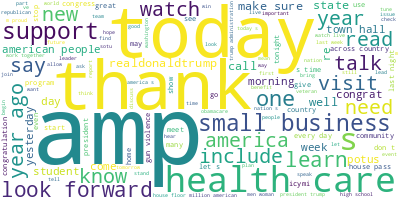

In [61]:
# creating a word cloud for the text_clean
long_string = ','.join(list(training_df["text_clean"].values))
wordcloud = WordCloud(background_color = "white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

In [62]:
# defining base variables for LDA and NMF
n_samples = len(training_df)
n_features = 1000
n_components = 10 # topic words / clusters set to 10 
n_top_words = 20 # number of words to display per topic 

In [63]:
# function to plot the top words in LDA and NMF
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=40)
    # plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [64]:
data_samples = training_df['text_clean'].tolist()

In [68]:
# extraction for LDA
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words='english'
)
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

done in 5.431s.


In [69]:
# fitting for LDA
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=10,
    learning_method='online',
    learning_offset=50.0,
    random_state=0,
)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

done in 467.590s.


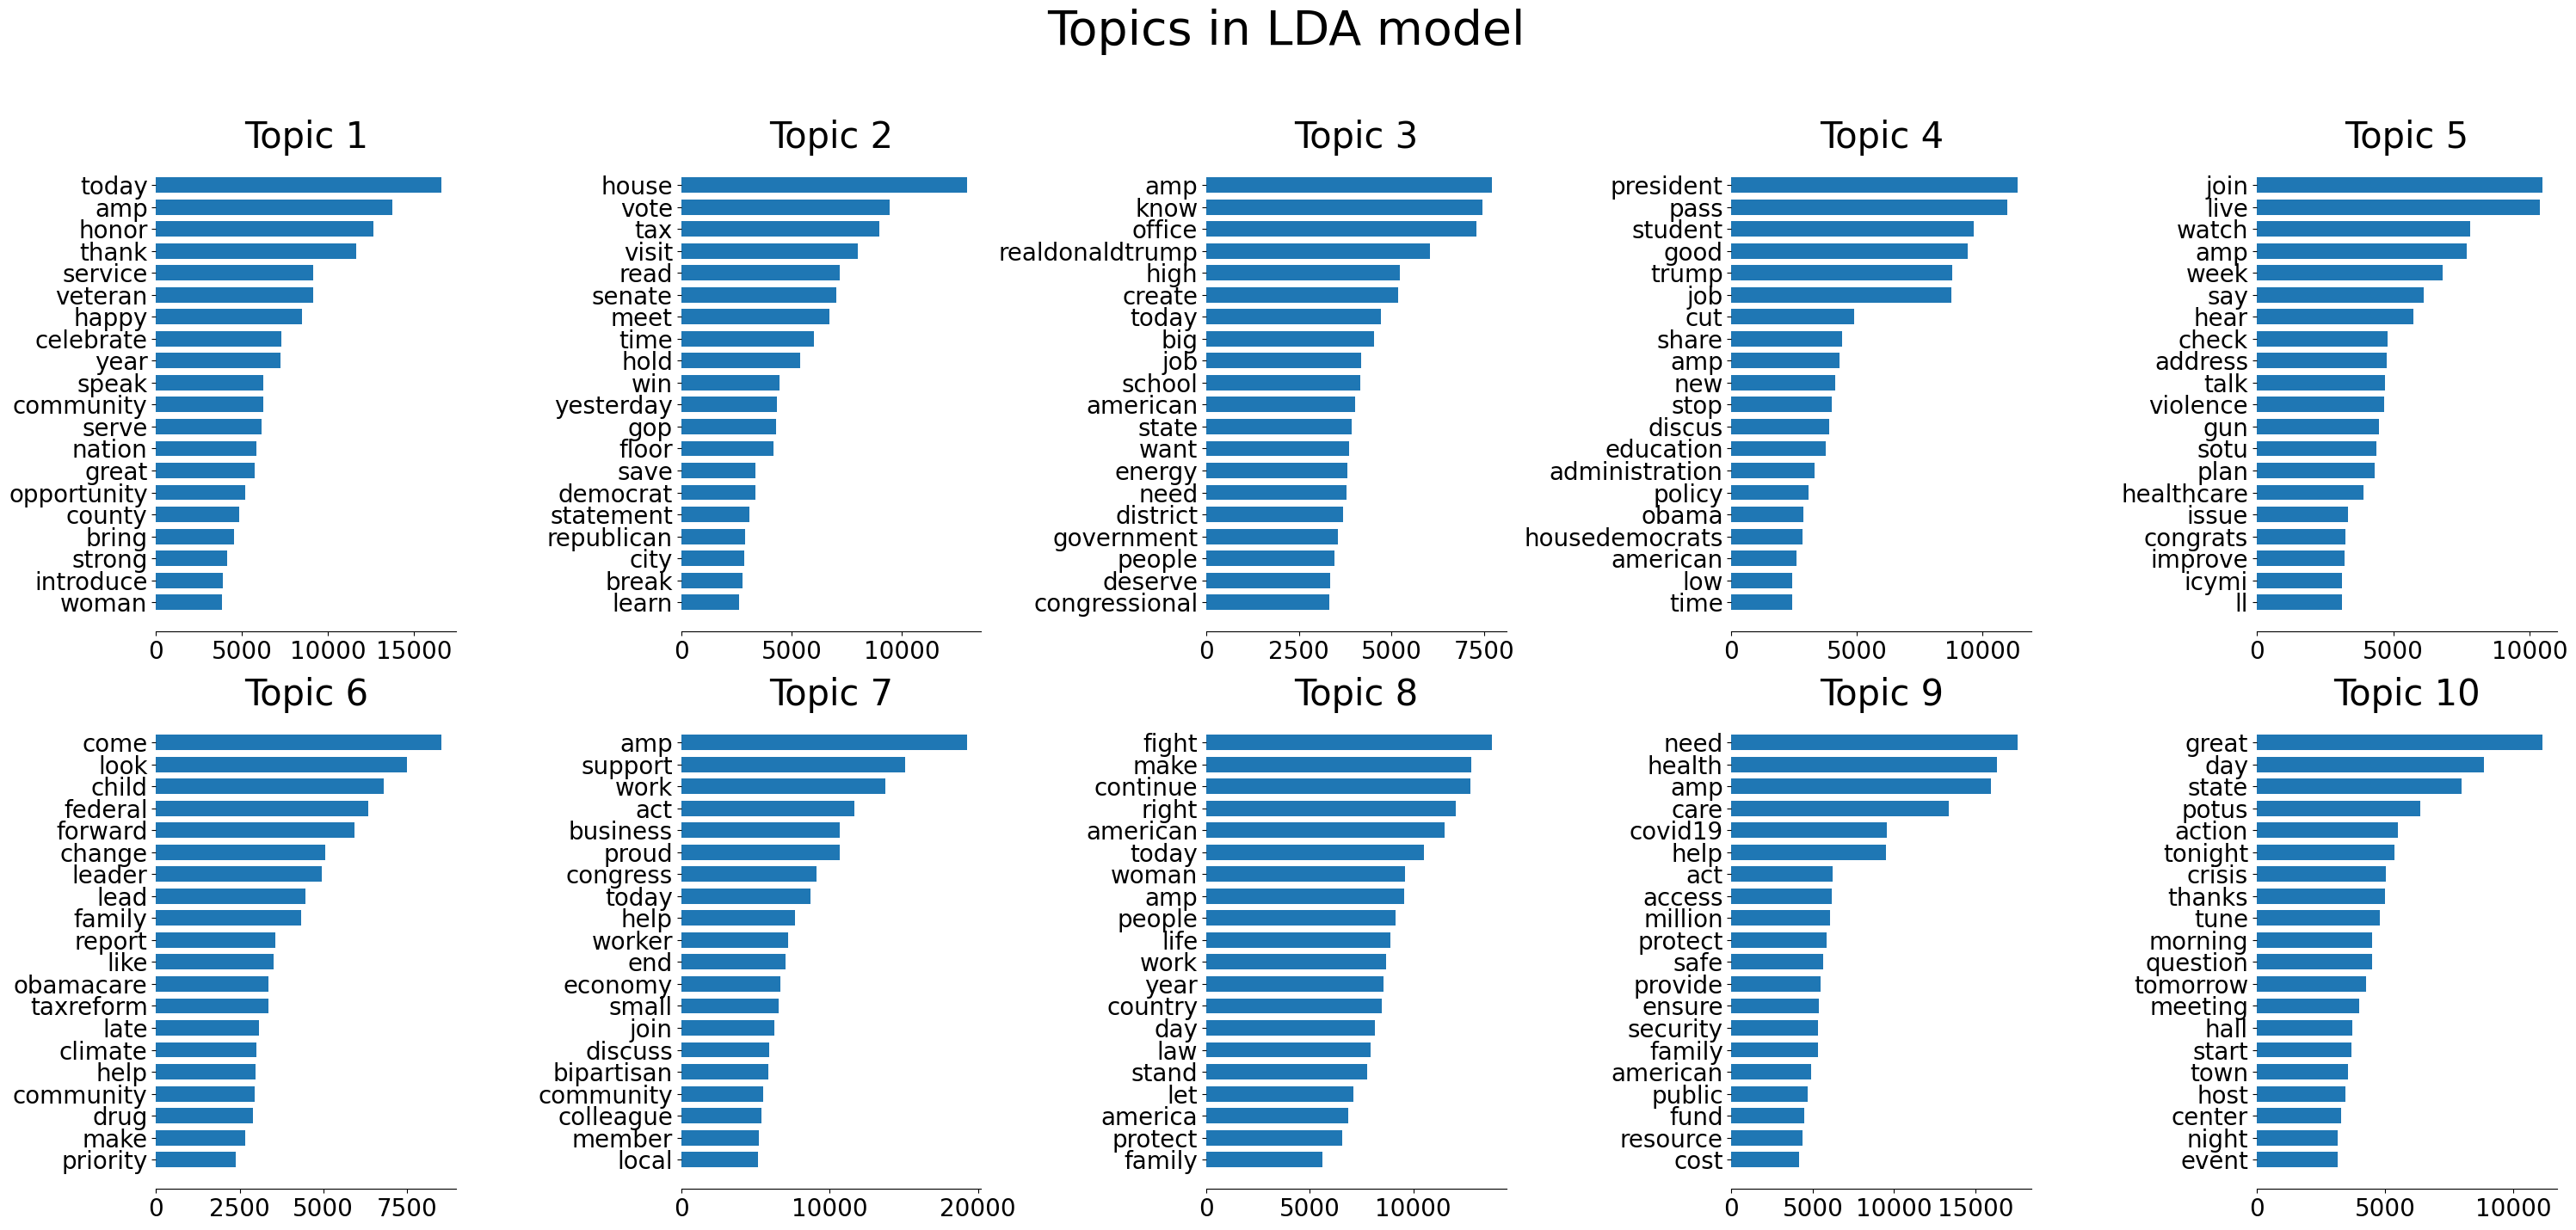

In [70]:
# plotting for LDA
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [71]:
# extraction for NMF
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words='english'
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

done in 6.338s.


In [72]:
# fitting NMF
t0 = time()
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init='nndsvda',
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("NMF fit done in %0.3fs." % (time() - t0))

NMF fit done in 82.001s.


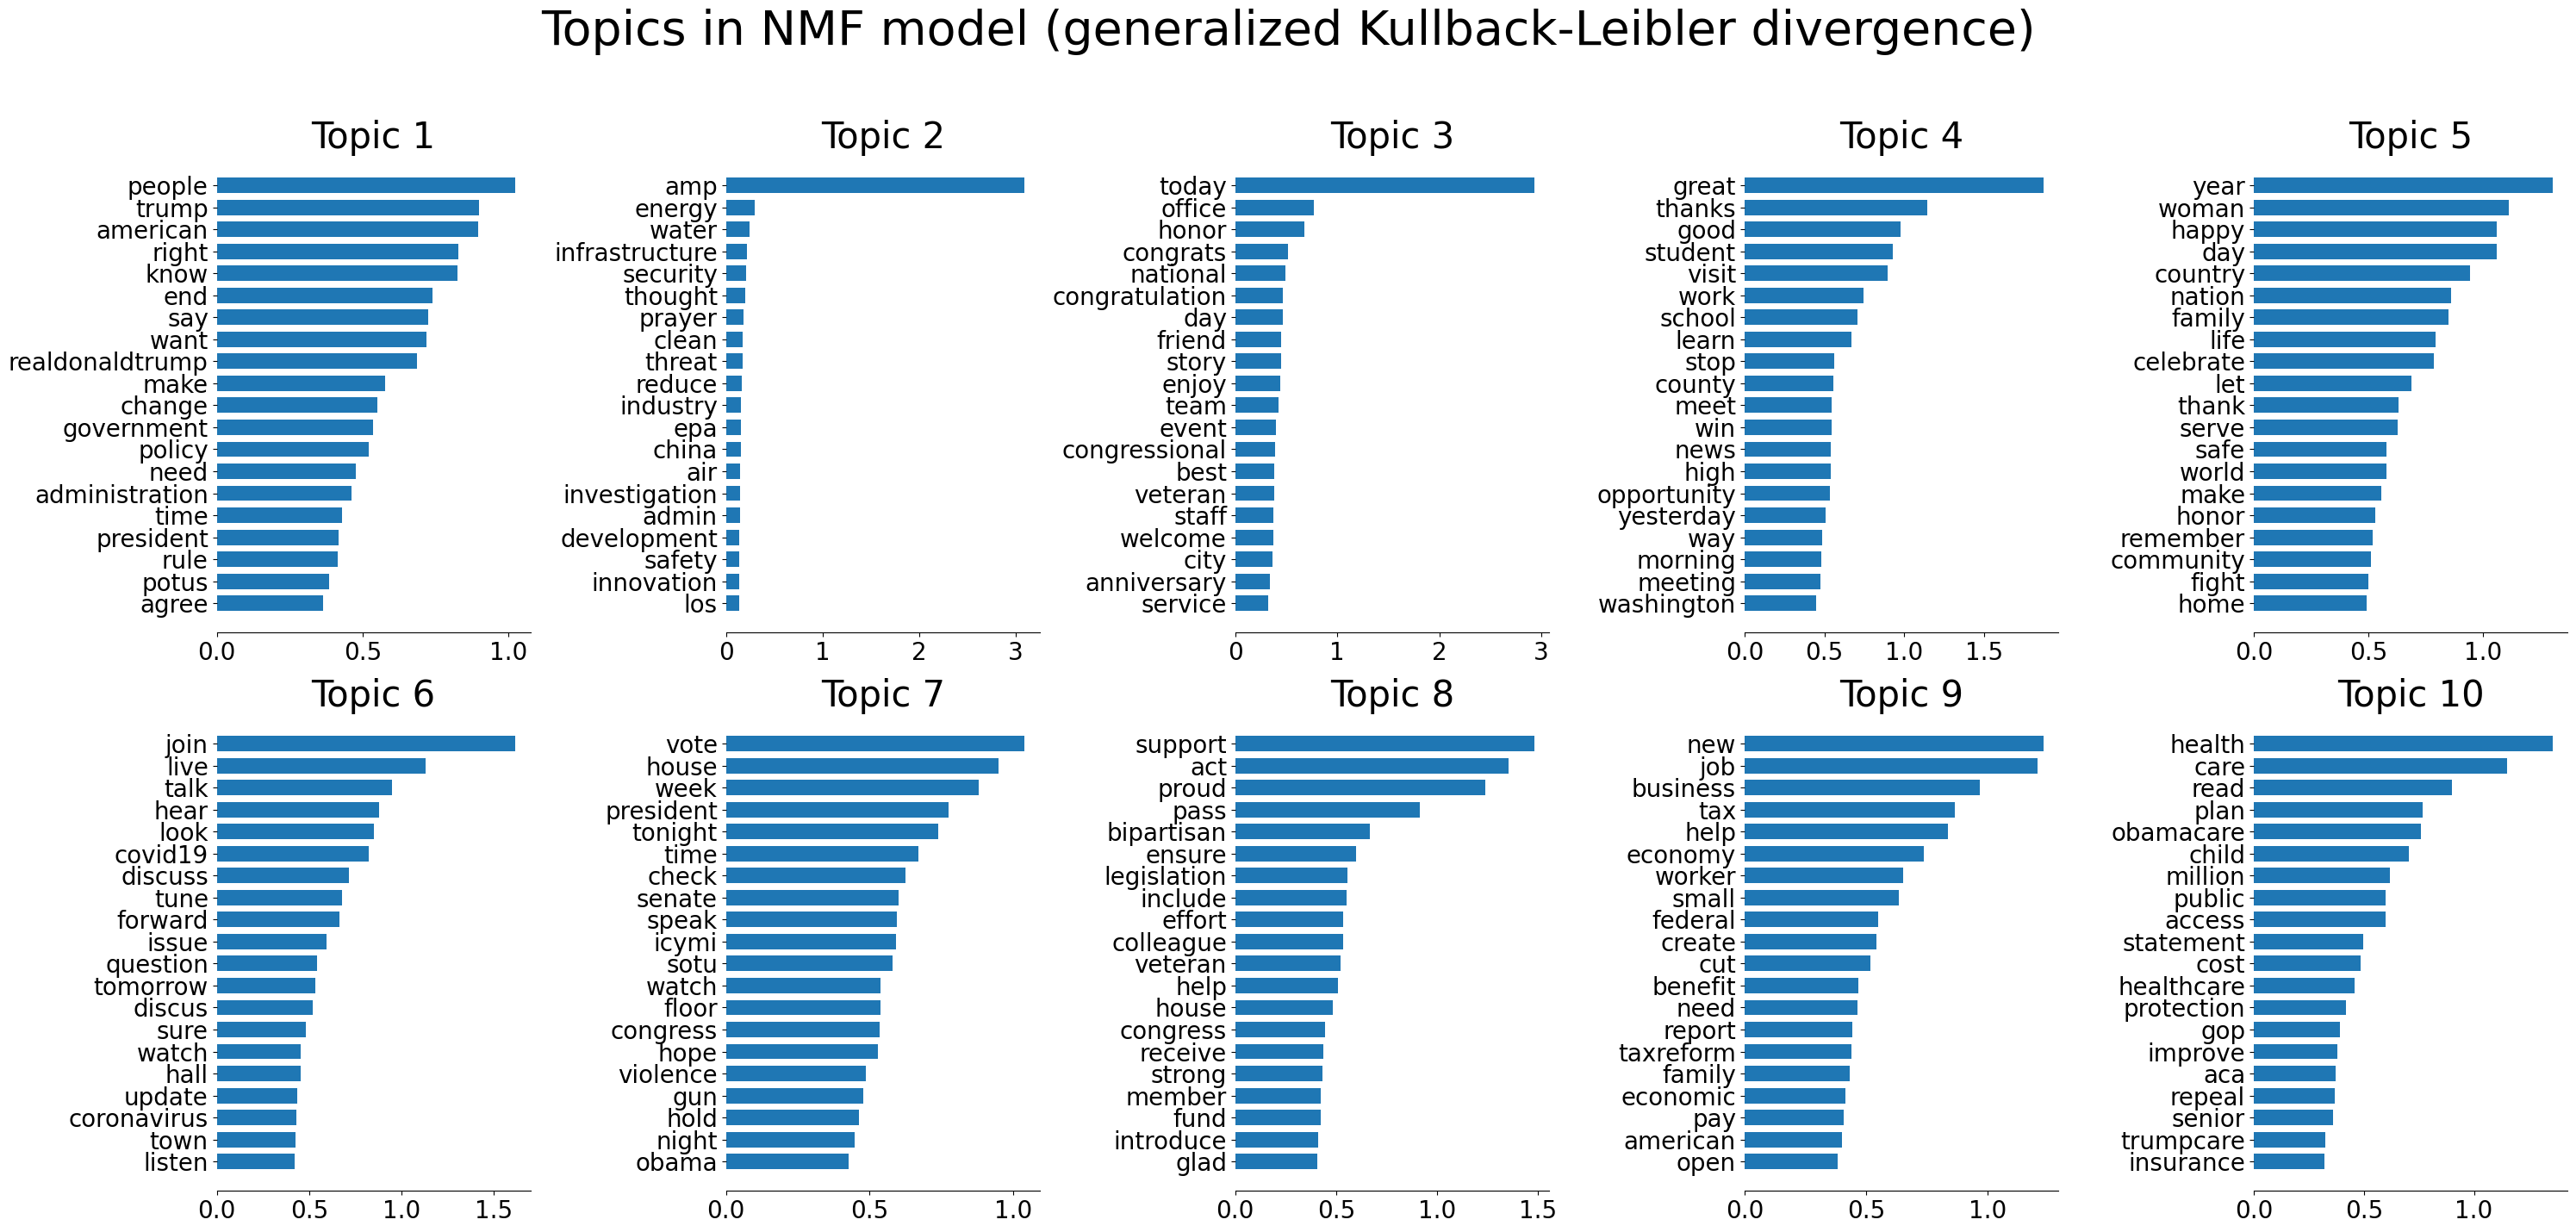

In [73]:
# plotting for NMF
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

Part II : Model Creation and Prediction

In [75]:
# defining the DistilBertTokenizer and DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [76]:
# function to generate embeddings from text using DistilBERT
def encode_texts(texts, batch_size=32):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
        
        with torch.no_grad():
            outputs = model(**encoded_input)
            embeddings = outputs.last_hidden_state[:, 0, :]  
            all_embeddings.append(embeddings)
    
    # Concatenating embeddings to form a tensor
    return torch.cat(all_embeddings, dim=0)

In [ ]:
# embedding from cleaned tweets
text_data = training_df['text_clean'].tolist()
text_embeddings = encode_texts(text_data, batch_size=32)

In [ ]:
# Convert embeddings tensor to DataFrame
embeddings_df = pd.DataFrame(text_embeddings.numpy())
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.030036,-0.168452,-0.077972,-0.039181,-0.076345,-0.238268,0.414181,0.319156,-0.135485,-0.357277,...,0.187417,-0.148253,-0.128650,-0.322952,0.261679,0.079278,-0.183858,-0.008026,0.080364,0.308733
1,-0.423020,-0.159571,-0.272636,-0.108693,-0.037246,0.040376,0.060200,0.123229,-0.201348,-0.465444,...,0.015367,-0.196191,0.173651,-0.115729,0.280817,-0.287414,0.024919,-0.024837,0.242226,0.332024
2,-0.036635,-0.043870,0.153796,0.045957,-0.110834,-0.090892,0.374880,0.309412,-0.075762,-0.352049,...,-0.032771,-0.231442,-0.141327,-0.095152,0.340841,-0.037721,-0.090725,-0.213731,0.125067,0.352086
3,0.071993,-0.116977,-0.169076,-0.439893,-0.184711,-0.297665,0.284581,0.248723,-0.065963,-0.264207,...,0.157113,-0.130913,0.331875,-0.030625,0.180599,-0.297679,0.030255,-0.536955,0.336836,-0.076894
4,-0.286426,-0.407624,-0.283652,-0.131598,0.009838,0.011336,0.167740,-0.180540,-0.161027,-0.531064,...,0.141250,-0.134295,-0.018937,-0.256435,0.260276,-0.149391,0.027058,-0.127364,-0.081815,0.331959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333982,-0.015959,-0.020017,0.129008,0.110753,0.182591,0.050627,0.266870,0.344408,-0.282375,-0.470636,...,0.046274,-0.260601,0.016969,-0.006023,0.116223,-0.068582,-0.140080,-0.304001,-0.028288,0.224712
333983,-0.200837,0.099300,-0.180502,0.130562,0.147347,-0.321029,0.354145,0.215825,-0.151490,-0.625016,...,0.068016,-0.247011,0.008690,0.019177,0.038628,-0.136204,-0.133212,-0.429900,0.320278,0.029803
333984,-0.210538,-0.120943,0.079614,-0.005887,-0.038669,-0.111149,0.101935,0.073038,-0.147876,-0.347898,...,0.054264,-0.275149,-0.062409,-0.158604,0.330298,0.047113,-0.092104,-0.229053,0.084403,0.273508
333985,-0.044304,-0.073137,0.202803,-0.067211,0.058240,0.025094,0.264492,0.283050,-0.177662,-0.215232,...,0.058418,-0.251123,0.008457,-0.058697,0.205992,-0.036501,-0.074478,-0.081301,0.187072,0.374848


In [ ]:
# embeddings_df.to_csv("embedded_text_to_numerical.csv")

In [77]:
embeddings_df = pd.read_csv("embedded_text_to_numerical.csv")

In [78]:
embeddings_df = embeddings_df.iloc[:,1:]
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.030036,-0.168452,-0.077972,-0.039181,-0.076345,-0.238268,0.414181,0.319156,-0.135485,-0.357277,...,0.187417,-0.148253,-0.128650,-0.322952,0.261679,0.079278,-0.183858,-0.008026,0.080364,0.308733
1,-0.423020,-0.159571,-0.272636,-0.108693,-0.037246,0.040376,0.060200,0.123229,-0.201348,-0.465444,...,0.015367,-0.196191,0.173651,-0.115729,0.280817,-0.287413,0.024919,-0.024837,0.242226,0.332024
2,-0.036635,-0.043870,0.153796,0.045957,-0.110834,-0.090892,0.374880,0.309412,-0.075762,-0.352049,...,-0.032771,-0.231442,-0.141327,-0.095152,0.340841,-0.037721,-0.090725,-0.213731,0.125067,0.352086
3,0.071993,-0.116977,-0.169076,-0.439893,-0.184711,-0.297665,0.284581,0.248723,-0.065963,-0.264207,...,0.157113,-0.130913,0.331875,-0.030625,0.180599,-0.297679,0.030255,-0.536955,0.336836,-0.076894
4,-0.286426,-0.407624,-0.283652,-0.131598,0.009838,0.011336,0.167740,-0.180540,-0.161027,-0.531064,...,0.141250,-0.134295,-0.018937,-0.256435,0.260276,-0.149391,0.027058,-0.127364,-0.081815,0.331959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333982,-0.015959,-0.020017,0.129008,0.110753,0.182591,0.050627,0.266870,0.344408,-0.282375,-0.470636,...,0.046274,-0.260601,0.016969,-0.006023,0.116223,-0.068582,-0.140080,-0.304001,-0.028288,0.224712
333983,-0.200837,0.099300,-0.180502,0.130562,0.147347,-0.321029,0.354145,0.215825,-0.151490,-0.625016,...,0.068016,-0.247011,0.008690,0.019177,0.038628,-0.136204,-0.133212,-0.429900,0.320278,0.029803
333984,-0.210538,-0.120943,0.079614,-0.005887,-0.038669,-0.111149,0.101935,0.073038,-0.147876,-0.347898,...,0.054264,-0.275149,-0.062409,-0.158604,0.330298,0.047113,-0.092104,-0.229053,0.084403,0.273508
333985,-0.044304,-0.073137,0.202803,-0.067211,0.058240,0.025094,0.264492,0.283050,-0.177662,-0.215232,...,0.058418,-0.251123,0.008457,-0.058697,0.205992,-0.036501,-0.074478,-0.081301,0.187072,0.374848


In [ ]:
# embedding for textual data is successful, now we deal with the hashtags

In [ ]:
# embedding for hashtags
hashtags_data = training_df['hashtags'].apply(' '.join).tolist()
hashtag_embeddings = encode_texts(hashtags_data, batch_size=32)

In [ ]:
hashtag_df = pd.DataFrame(hashtag_embeddings.numpy())
hashtag_df

In [ ]:
# hashtag_df.to_csv("hashtag_embeddings.csv")

In [79]:
hashtag_embeddings = pd.read_csv("hashtag_embeddings.csv")

In [80]:
hashtag_embeddings = hashtag_embeddings.iloc[:,1:]
hashtag_embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.186711,-0.116146,0.154639,-0.191096,0.051013,-0.255334,0.648092,0.439262,-0.093871,-0.202292,...,0.340957,-0.146765,0.009469,-0.210503,0.363374,-0.310779,-0.012890,-0.163686,0.069325,0.747586
1,-0.189338,-0.003268,0.113402,-0.281253,-0.069090,-0.173468,0.579213,0.410745,-0.054173,-0.102541,...,0.241709,-0.165234,-0.120156,-0.167368,0.415954,-0.309612,0.030776,-0.176098,0.081087,0.699038
2,-0.274580,-0.121258,0.099798,-0.190975,-0.178797,-0.193064,0.660059,0.570659,-0.187522,-0.198797,...,0.331151,-0.205287,0.094416,-0.072482,0.363398,-0.450906,0.071931,-0.087531,0.042406,0.659158
3,-0.130516,-0.055844,0.181737,-0.255575,-0.073198,-0.013344,0.240417,0.257228,-0.201375,-0.210134,...,0.131997,-0.055321,0.165263,-0.047893,0.213769,-0.190763,0.012251,-0.057630,0.229907,0.561936
4,-0.285859,-0.136789,0.270213,-0.248674,-0.092952,-0.176840,0.161238,0.214777,-0.107096,-0.118865,...,0.331157,0.055599,0.107039,-0.144922,0.314654,-0.212100,-0.112837,0.011616,0.190735,0.539244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333982,-0.246966,-0.081267,0.261200,-0.132891,-0.092061,-0.270211,0.631661,0.542847,-0.002523,-0.179306,...,0.333062,-0.168364,-0.131364,-0.169139,0.412004,-0.281279,0.080757,-0.224385,0.004740,0.839955
333983,-0.182492,-0.070536,0.109312,-0.281930,0.017169,-0.183520,0.479379,0.393638,-0.126101,-0.221241,...,0.228436,-0.063050,0.050693,-0.073733,0.336977,-0.356233,0.092138,-0.138569,0.146901,0.706970
333984,-0.075310,0.013386,0.040342,-0.296659,0.007312,-0.170234,0.430806,0.286889,-0.115703,-0.267024,...,0.138122,-0.021165,-0.026740,-0.115214,0.309313,-0.279347,0.090161,-0.114444,0.204574,0.650078
333985,-0.110654,-0.236615,0.081133,-0.414764,-0.000380,-0.103479,0.389716,0.365153,-0.114965,-0.240878,...,0.251988,-0.117744,0.071637,-0.085581,0.409545,-0.425611,0.064114,-0.262581,0.064469,0.618062


In [81]:
final_training_df = pd.concat([embeddings_df,hashtag_embeddings,training_df[["favorite_count","retweet_count","year","dim1_nominate","dim2_nominate"]]],axis=1,ignore_index=True)
final_training_df

,0,1,2,3,4,5,6,7,8,9,...,1531,1532,1533,1534,1535,1536,1537,1538,1539,1540
0,0.030036,-0.168452,-0.077972,-0.039181,-0.076345,-0.238268,0.414181,0.319156,-0.135485,-0.357277,...,-0.310779,-0.012890,-0.163686,0.069325,0.747586,8,3,2017,0.243962,0.170366
1,-0.423020,-0.159571,-0.272636,-0.108693,-0.037246,0.040376,0.060200,0.123229,-0.201348,-0.465444,...,-0.309612,0.030776,-0.176098,0.081087,0.699038,2,3,2015,0.561728,0.089540
2,-0.036635,-0.043870,0.153796,0.045957,-0.110834,-0.090892,0.374880,0.309412,-0.075762,-0.352049,...,-0.450906,0.071931,-0.087531,0.042406,0.659158,5,4,2014,0.513246,-0.224541
3,0.071993,-0.116977,-0.169076,-0.439893,-0.184711,-0.297665,0.284581,0.248723,-0.065963,-0.264207,...,-0.190763,0.012251,-0.057630,0.229907,0.561936,34,14,2017,-0.241932,0.097843
4,-0.286426,-0.407624,-0.283652,-0.131598,0.009838,0.011336,0.167740,-0.180540,-0.161027,-0.531064,...,-0.212100,-0.112837,0.011616,0.190735,0.539244,23,7,2020,-0.225722,0.329999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333982,-0.015959,-0.020017,0.129008,0.110753,0.182591,0.050627,0.266870,0.344408,-0.282375,-0.470636,...,-0.281279,0.080757,-0.224385,0.004740,0.839955,97,29,2018,-0.423522,0.005929
333983,-0.200837,0.099300,-0.180502,0.130562,0.147347,-0.321029,0.354145,0.215825,-0.151490,-0.625016,...,-0.356233,0.092138,-0.138569,0.146901,0.706970,11,11,2016,-0.436272,-0.546745
333984,-0.210538,-0.120943,0.079614,-0.005887,-0.038669,-0.111149,0.101935,0.073038,-0.147876,-0.347898,...,-0.279347,0.090161,-0.114444,0.204574,0.650078,82,34,2019,-0.309244,-0.070852
333985,-0.044304,-0.073137,0.202803,-0.067211,0.058240,0.025094,0.264492,0.283050,-0.177662,-0.215232,...,-0.425611,0.064114,-0.262581,0.064469,0.618062,1,1,2016,-0.516671,0.205851


In [ ]:
# final_training_df.to_csv("combined_numerical.csv")

In [87]:
# separating training data and target variables
X = final_training_df.iloc[:,:-2]
y = final_training_df.iloc[:,1539:]

In [88]:
X

,0,1,2,3,4,5,6,7,8,9,...,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538
0,0.030036,-0.168452,-0.077972,-0.039181,-0.076345,-0.238268,0.414181,0.319156,-0.135485,-0.357277,...,-0.210503,0.363374,-0.310779,-0.012890,-0.163686,0.069325,0.747586,8,3,2017
1,-0.423020,-0.159571,-0.272636,-0.108693,-0.037246,0.040376,0.060200,0.123229,-0.201348,-0.465444,...,-0.167368,0.415954,-0.309612,0.030776,-0.176098,0.081087,0.699038,2,3,2015
2,-0.036635,-0.043870,0.153796,0.045957,-0.110834,-0.090892,0.374880,0.309412,-0.075762,-0.352049,...,-0.072482,0.363398,-0.450906,0.071931,-0.087531,0.042406,0.659158,5,4,2014
3,0.071993,-0.116977,-0.169076,-0.439893,-0.184711,-0.297665,0.284581,0.248723,-0.065963,-0.264207,...,-0.047893,0.213769,-0.190763,0.012251,-0.057630,0.229907,0.561936,34,14,2017
4,-0.286426,-0.407624,-0.283652,-0.131598,0.009838,0.011336,0.167740,-0.180540,-0.161027,-0.531064,...,-0.144922,0.314654,-0.212100,-0.112837,0.011616,0.190735,0.539244,23,7,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333982,-0.015959,-0.020017,0.129008,0.110753,0.182591,0.050627,0.266870,0.344408,-0.282375,-0.470636,...,-0.169139,0.412004,-0.281279,0.080757,-0.224385,0.004740,0.839955,97,29,2018
333983,-0.200837,0.099300,-0.180502,0.130562,0.147347,-0.321029,0.354145,0.215825,-0.151490,-0.625016,...,-0.073733,0.336977,-0.356233,0.092138,-0.138569,0.146901,0.706970,11,11,2016
333984,-0.210538,-0.120943,0.079614,-0.005887,-0.038669,-0.111149,0.101935,0.073038,-0.147876,-0.347898,...,-0.115214,0.309313,-0.279347,0.090161,-0.114444,0.204574,0.650078,82,34,2019
333985,-0.044304,-0.073137,0.202803,-0.067211,0.058240,0.025094,0.264492,0.283050,-0.177662,-0.215232,...,-0.085581,0.409545,-0.425611,0.064114,-0.262581,0.064469,0.618062,1,1,2016


In [89]:
y

,1539,1540
0,0.243962,0.170366
1,0.561728,0.089540
2,0.513246,-0.224541
3,-0.241932,0.097843
4,-0.225722,0.329999
...,...,...
333982,-0.423522,0.005929
333983,-0.436272,-0.546745
333984,-0.309244,-0.070852
333985,-0.516671,0.205851


In [90]:
# checking training data for null values
X.isnull().sum().sum()

0

In [91]:
# checking target variables for null values
y.isnull().sum().sum()

0

In [92]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
# # Initialize XGBoost regressor with default parameters
# xgb_regressor = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=100,
#     max_depth=6,
#     learning_rate=0.1,
#     n_jobs=-1,
#     random_state=42
# )

In [94]:
# model_xgb = MultiOutputRegressor(xgb_regressor)
# model_xgb.fit(X_train,y_train)
# model_xgb.fit(X,y)
# y_pred = model_xgb.predict(X_test)
# y_test.iloc[:,-2]

In [95]:
# rmse_dim1 = root_mean_squared_error(y_test.iloc[:,-2],y_pred[:,0])
# rmse_dim2 = root_mean_squared_error(y_test.iloc[:,-1],y_pred[:,1])

# print(rmse_dim1)
# print(rmse_dim2)
# print((rmse_dim1+rmse_dim2)/2)

In [96]:
# rf_regressor = RandomForestRegressor(
#     n_estimators=300,
#     max_depth=None,
#     random_state=42,
#     n_jobs=-1
# )

In [98]:
# rf_regressor.fit(X, y)

In [99]:
# import joblib

# joblib.dump(rf_regressor, 'rf_regressor_model2.pkl')

# print("Model saved successfully to 'rf_regressor_model2.pkl'")

In [ ]:
# # Predict on validation data
# y_pred = rf_regressor.predict(X_test)

In [ ]:
# rmse_dim1 = root_mean_squared_error(y_test.iloc[:,-2],y_pred[:,0])
# rmse_dim2 = root_mean_squared_error(y_test.iloc[:,-1],y_pred[:,1])

# print(rmse_dim1)
# print(rmse_dim2)
# print((rmse_dim1+rmse_dim2)/2)

In [100]:
# now processing the test data
test_data = pd.read_csv("test_data.csv")
test_data

,Id,favorite_count,full_text,hashtags,retweet_count,year,dim1_nominate,dim2_nominate
0,0,0,"b""Watch my opening statement from today's hearing on EPA's assault on the Appalachian mining industry http://youtu.be/UUv5pg8ZSO8 #jobs""",jobs,0,2011,NaN,NaN
1,1,0,b'I voted against the GOP #budget today that gives tax breaks to the rich on the backs of working families http://bit.ly/fBZKZo #p2',budget p2,2,2011,NaN,NaN
2,2,0,b'Hosting a Breakfast For Central Coast Vets in #SantaMaria on Monday. Members of the Central Coast Vets service community will be there too',SantaMaria,0,2012,NaN,NaN
3,3,87,"b'Thousands of people have died, hundreds of thousands injured, millions and billions of taxpayer dollars wasted \xe2\x80\x93 all because Congress passed a 60-word blank check for war over 18 years ago. We cannot allow this to continue \xe2\x80\x93 it\xe2\x80\x99s time to #StopEndlessWar. https://t.co/91w95aeliE'",StopEndlessWar,24,2019,NaN,NaN
4,4,16,"b'Meet Blake, too. He\xe2\x80\x99s runs his own snow cone shop. Because of ABLE to Work, my bill that became law in #taxreform, he will be able to save more of what he earns. https://t.co/g8XIW5K185'",taxreform,3,2018,NaN,NaN
...,...,...,...,...,...,...,...,...
135748,135748,41,b'#ForeverGIBill will be voted on in the House next week.',ForeverGIBill,17,2017,NaN,NaN
135749,135749,15,b'Americans deserve to know if Trump and his campaign team communicated with the Russians before the election. #investigatetrump',investigatetrump,1,2017,NaN,NaN
135750,135750,9,"b'Apparently Democrat #Perez hasn\xe2\x80\x99t read tax bill, but then again he\xe2\x80\x99s been so busy finding out who paid for #Dossier https://t.co/oe41MKtSad'",Perez Dossier,0,2017,NaN,NaN
135751,135751,3,"b""2/2..weren\xe2\x80\x99t included as a US priority by our negotiators during recent US-Taliban peace talks. I plan to hold a hearing in the near future on the Administration's implementation of the #WPS strategy to help ensure it's actually used to inform US foreign policy &amp; development aid.""",WPS,1,2020,NaN,NaN


In [101]:
test_df = pd.DataFrame(data=test_data, columns=["favorite_count","full_text","hashtags","retweet_count","year"])
test_df

,favorite_count,full_text,hashtags,retweet_count,year
0,0,"b""Watch my opening statement from today's hearing on EPA's assault on the Appalachian mining industry http://youtu.be/UUv5pg8ZSO8 #jobs""",jobs,0,2011
1,0,b'I voted against the GOP #budget today that gives tax breaks to the rich on the backs of working families http://bit.ly/fBZKZo #p2',budget p2,2,2011
2,0,b'Hosting a Breakfast For Central Coast Vets in #SantaMaria on Monday. Members of the Central Coast Vets service community will be there too',SantaMaria,0,2012
3,87,"b'Thousands of people have died, hundreds of thousands injured, millions and billions of taxpayer dollars wasted \xe2\x80\x93 all because Congress passed a 60-word blank check for war over 18 years ago. We cannot allow this to continue \xe2\x80\x93 it\xe2\x80\x99s time to #StopEndlessWar. https://t.co/91w95aeliE'",StopEndlessWar,24,2019
4,16,"b'Meet Blake, too. He\xe2\x80\x99s runs his own snow cone shop. Because of ABLE to Work, my bill that became law in #taxreform, he will be able to save more of what he earns. https://t.co/g8XIW5K185'",taxreform,3,2018
...,...,...,...,...,...
135748,41,b'#ForeverGIBill will be voted on in the House next week.',ForeverGIBill,17,2017
135749,15,b'Americans deserve to know if Trump and his campaign team communicated with the Russians before the election. #investigatetrump',investigatetrump,1,2017
135750,9,"b'Apparently Democrat #Perez hasn\xe2\x80\x99t read tax bill, but then again he\xe2\x80\x99s been so busy finding out who paid for #Dossier https://t.co/oe41MKtSad'",Perez Dossier,0,2017
135751,3,"b""2/2..weren\xe2\x80\x99t included as a US priority by our negotiators during recent US-Taliban peace talks. I plan to hold a hearing in the near future on the Administration's implementation of the #WPS strategy to help ensure it's actually used to inform US foreign policy &amp; development aid.""",WPS,1,2020


In [102]:
# decoding byte string for tweets in test data
test_df["full_text"] = test_df["full_text"].apply(byte_string_decode)
test_df["full_text"].to_list()

["Watch my opening statement from today's hearing on EPA's assault on the Appalachian mining industry http://youtu.be/UUv5pg8ZSO8 #jobs",
 'I voted against the GOP #budget today that gives tax breaks to the rich on the backs of working families http://bit.ly/fBZKZo #p2',
 'Hosting a Breakfast For Central Coast Vets in #SantaMaria on Monday. Members of the Central Coast Vets service community will be there too',
 'Thousands of people have died, hundreds of thousands injured, millions and billions of taxpayer dollars wasted – all because Congress passed a 60-word blank check for war over 18 years ago. We cannot allow this to continue – it’s time to #StopEndlessWar. https://t.co/91w95aeliE',
 'Meet Blake, too. He’s runs his own snow cone shop. Because of ABLE to Work, my bill that became law in #taxreform, he will be able to save more of what he earns. https://t.co/g8XIW5K185',
 "Getting ready to talk w/ @tonykatz on @93wibc about last night's #JointAddress &amp; @POTUS Trump's vision for

In [103]:
# applying cleaning, lemmatization, etc on test data
test_df = parallelize_dataframe(test_df, apply_lemmatize_to_chunk, n_cores)
test_df

/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,favorite_count,full_text,hashtags,retweet_count,year,text_clean
0,0,Watch my opening statement from today's hearing on EPA's assault on the Appalachian mining industry http://youtu.be/UUv5pg8ZSO8 #jobs,jobs,0,2011,watch open statement today hear epas assault appalachian mining industry
1,0,I voted against the GOP #budget today that gives tax breaks to the rich on the backs of working families http://bit.ly/fBZKZo #p2,budget p2,2,2011,voted gop budget today give tax break rich back work family
2,0,Hosting a Breakfast For Central Coast Vets in #SantaMaria on Monday. Members of the Central Coast Vets service community will be there too,SantaMaria,0,2012,host breakfast central coast vet santamaria monday member central coast vet service community
3,87,"Thousands of people have died, hundreds of thousands injured, millions and billions of taxpayer dollars wasted – all because Congress passed a 60-word blank check for war over 18 years ago. We cannot allow this to continue – it’s time to #StopEndlessWar. https://t.co/91w95aeliE",StopEndlessWar,24,2019,thousand people die hundred thousand injured million billion taxpayer dollar waste congress pass 60word blank check war year ago can not allow continue it ’ s time stopendlesswar
4,16,"Meet Blake, too. He’s runs his own snow cone shop. Because of ABLE to Work, my bill that became law in #taxreform, he will be able to save more of what he earns. https://t.co/g8XIW5K185",taxreform,3,2018,meet blake he ’ s run snow cone shop able work bill become law taxreform able save earns
...,...,...,...,...,...,...
135748,41,#ForeverGIBill will be voted on in the House next week.,ForeverGIBill,17,2017,forevergibill vote house next week
135749,15,Americans deserve to know if Trump and his campaign team communicated with the Russians before the election. #investigatetrump,investigatetrump,1,2017,american deserve know trump campaign team communicate russian election investigatetrump
135750,9,"Apparently Democrat #Perez hasn’t read tax bill, but then again he’s been so busy finding out who paid for #Dossier https://t.co/oe41MKtSad",Perez Dossier,0,2017,apparently democrat perez hasn ’ t read tax bill he ’ s busy find pay dossier
135751,3,2/2..weren’t included as a US priority by our negotiators during recent US-Taliban peace talks. I plan to hold a hearing in the near future on the Administration's implementation of the #WPS strategy to help ensure it's actually used to inform US foreign policy &amp; development aid.,WPS,1,2020,22weren ’ t include priority negotiator recent ustaliban peace talk plan hold hearing near future administration implementation wps strategy help ensure actually use inform foreign policy amp development aid


In [ ]:
# embeddings for tweets in test data
text_data_test = test_df["text_clean"].tolist()
text_embeddings_test = encode_texts(text_data_test,batch_size=15)

In [ ]:
embeddings_test_df = pd.DataFrame(text_embeddings_test.numpy())
embeddings_test_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.033586,-0.063356,-0.199021,-0.251829,0.033936,-0.358489,0.274618,0.248905,-0.252766,-0.188773,...,0.112345,0.061097,-0.183769,-0.182104,0.271352,-0.234193,0.010677,-0.239052,0.194539,0.068031
1,-0.185250,-0.311036,-0.095289,-0.024530,-0.054578,-0.098067,0.082847,0.250280,-0.314318,-0.304318,...,-0.125766,-0.092529,0.056330,-0.022647,0.398921,-0.096983,-0.054569,-0.121448,0.251127,0.195839
2,-0.166209,-0.067604,-0.153208,-0.390708,-0.071230,0.039934,0.355563,0.152409,0.056281,-0.195357,...,0.126209,-0.152541,-0.119816,-0.274673,0.170873,-0.256769,-0.175238,-0.038371,0.353538,0.292430
3,0.147827,-0.026006,-0.038596,0.069530,-0.132474,-0.095113,0.275984,0.587553,-0.298776,-0.216946,...,-0.033371,-0.086171,-0.002681,-0.143302,0.365504,0.038414,-0.093421,-0.029014,0.345626,0.242682
4,-0.043919,-0.075544,0.176992,-0.003559,0.066645,-0.161423,0.425384,0.324419,-0.245945,-0.231244,...,-0.133934,-0.216474,-0.123460,-0.120155,0.203926,0.104519,-0.179303,-0.207362,0.121096,0.166623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135748,-0.162000,-0.367957,0.403493,0.089422,-0.104566,-0.057766,0.463177,0.150471,-0.267550,-0.214041,...,-0.007321,-0.069942,0.264292,-0.180855,0.245185,-0.129010,0.068364,-0.316806,0.203781,0.247831
135749,-0.139007,-0.052342,-0.152782,0.074962,-0.112662,-0.164328,0.133151,0.079008,-0.096414,-0.179264,...,0.061195,-0.035200,0.060968,-0.107937,0.312744,0.008352,-0.086782,-0.100510,0.293299,0.325246
135750,-0.114225,-0.027148,0.138809,0.057307,0.020765,-0.222911,-0.014519,0.325451,-0.357701,-0.172008,...,-0.106483,0.109549,-0.093941,0.074555,0.094363,-0.025144,-0.067189,-0.106255,0.195253,0.153049
135751,-0.204281,-0.102883,-0.036518,0.062203,-0.039200,-0.121758,0.003352,0.072296,-0.008460,-0.396416,...,0.163198,-0.201164,0.028409,-0.137012,0.168902,-0.154734,-0.009612,-0.130153,0.244010,0.148610


In [ ]:
# embeddings_test_df.to_csv("embedded_text_to_numerical_TEST.csv")

In [104]:
embeddings_test_df = pd.read_csv("embedded_text_to_numerical_TEST.csv")
embeddings_test_df = embeddings_test_df.iloc[:,1:]
embeddings_test_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.033586,-0.063356,-0.199021,-0.251829,0.033936,-0.358489,0.274618,0.248905,-0.252766,-0.188773,...,0.112345,0.061097,-0.183769,-0.182104,0.271352,-0.234193,0.010677,-0.239052,0.194539,0.068031
1,-0.185250,-0.311036,-0.095289,-0.024530,-0.054578,-0.098067,0.082847,0.250280,-0.314318,-0.304318,...,-0.125766,-0.092529,0.056330,-0.022647,0.398921,-0.096983,-0.054569,-0.121447,0.251127,0.195839
2,-0.166209,-0.067604,-0.153208,-0.390708,-0.071230,0.039934,0.355563,0.152409,0.056281,-0.195357,...,0.126209,-0.152541,-0.119816,-0.274673,0.170873,-0.256769,-0.175237,-0.038371,0.353538,0.292430
3,0.147827,-0.026006,-0.038596,0.069530,-0.132474,-0.095113,0.275984,0.587553,-0.298776,-0.216946,...,-0.033371,-0.086171,-0.002681,-0.143302,0.365504,0.038414,-0.093421,-0.029014,0.345626,0.242682
4,-0.043919,-0.075544,0.176992,-0.003559,0.066645,-0.161423,0.425384,0.324419,-0.245945,-0.231244,...,-0.133934,-0.216474,-0.123460,-0.120155,0.203926,0.104519,-0.179303,-0.207362,0.121096,0.166623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135748,-0.162000,-0.367957,0.403493,0.089422,-0.104566,-0.057766,0.463177,0.150471,-0.267550,-0.214041,...,-0.007321,-0.069942,0.264292,-0.180855,0.245185,-0.129010,0.068364,-0.316806,0.203781,0.247831
135749,-0.139007,-0.052342,-0.152782,0.074962,-0.112662,-0.164328,0.133151,0.079008,-0.096414,-0.179264,...,0.061195,-0.035200,0.060968,-0.107937,0.312744,0.008352,-0.086782,-0.100510,0.293299,0.325246
135750,-0.114225,-0.027148,0.138809,0.057307,0.020765,-0.222911,-0.014519,0.325451,-0.357701,-0.172008,...,-0.106483,0.109549,-0.093941,0.074555,0.094363,-0.025144,-0.067189,-0.106255,0.195253,0.153049
135751,-0.204281,-0.102883,-0.036518,0.062203,-0.039200,-0.121758,0.003352,0.072296,-0.008460,-0.396416,...,0.163198,-0.201164,0.028409,-0.137012,0.168902,-0.154734,-0.009612,-0.130153,0.244010,0.148610


In [ ]:
# hashtag embedding for test data
hashtags_data_test = test_df['hashtags'].apply(" ".join).tolist()
hashtag_embeddings_test = encode_texts(hashtags_data_test, batch_size=15)

In [ ]:
hashtag_df_test = pd.DataFrame(hashtag_embeddings_test.numpy())
hashtag_df_test

In [ ]:
# hashtag_df_test.to_csv("hashtag_embeddings_TEST.csv")

In [105]:
hashtag_embeddings_test = pd.read_csv("hashtag_embeddings_TEST.csv")
hashtag_embeddings_test = hashtag_embeddings_test.iloc[:,1:]
hashtag_embeddings_test

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.087780,0.043003,0.032469,-0.295137,0.011033,-0.073916,0.262429,0.249212,-0.262892,-0.104842,...,0.108174,0.061300,0.023689,-0.104027,0.365728,-0.300121,-0.063127,-0.005819,0.250839,0.419627
1,-0.365135,-0.016733,0.337272,-0.375173,-0.027866,-0.281307,0.512807,0.386351,-0.069541,-0.172142,...,0.207524,-0.150615,0.126253,-0.161315,0.461254,-0.360472,0.082364,-0.162643,0.110172,0.601217
2,-0.076428,-0.104771,0.154826,-0.288978,0.019985,-0.152186,0.545849,0.406806,-0.001992,-0.137497,...,0.196762,-0.043581,-0.138682,-0.107806,0.171663,-0.298746,0.072424,-0.170603,0.159232,0.774038
3,-0.207969,-0.138539,0.027625,-0.254572,-0.029469,-0.198403,0.482571,0.386507,-0.110019,-0.178065,...,0.299852,-0.139839,0.047920,-0.168149,0.405971,-0.382875,0.082563,-0.211035,0.044291,0.705337
4,-0.159053,-0.049090,0.133326,-0.279980,0.007520,-0.116076,0.412069,0.319134,-0.018477,-0.253932,...,0.311545,-0.214374,0.007581,-0.122331,0.266655,-0.224870,0.085385,-0.103361,0.112737,0.661941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135748,-0.177672,-0.234965,0.167088,-0.374475,-0.032221,-0.204408,0.434397,0.330995,0.040983,-0.311546,...,0.323416,-0.086374,0.025156,-0.066965,0.361604,-0.336014,0.096718,-0.229890,0.121242,0.629280
135749,-0.195488,-0.031076,0.223363,-0.246186,-0.063722,-0.105818,0.692518,0.412612,-0.104385,-0.106812,...,0.191615,-0.229848,-0.011810,-0.233077,0.349579,-0.317440,0.139242,-0.087617,0.076151,0.733014
135750,-0.252119,-0.016297,0.161554,-0.213525,-0.113294,-0.187246,0.567448,0.239125,-0.022470,-0.222852,...,0.303899,-0.151045,-0.045119,-0.168844,0.411652,-0.390782,0.071222,-0.249923,0.096404,0.693609
135751,-0.157014,0.022694,0.052776,-0.236428,-0.114213,-0.026744,0.176668,0.170532,-0.187776,-0.106334,...,0.183081,-0.047216,0.047799,-0.183697,0.391463,-0.185757,-0.007080,-0.039604,0.120701,0.489455


In [106]:
final_test_df = pd.concat([embeddings_test_df,hashtag_embeddings_test,test_df[["favorite_count","retweet_count","year"]]],axis=1,ignore_index=True)
final_test_df

,0,1,2,3,4,5,6,7,8,9,...,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538
0,-0.033586,-0.063356,-0.199021,-0.251829,0.033936,-0.358489,0.274618,0.248905,-0.252766,-0.188773,...,-0.104027,0.365728,-0.300121,-0.063127,-0.005819,0.250839,0.419627,0,0,2011
1,-0.185250,-0.311036,-0.095289,-0.024530,-0.054578,-0.098067,0.082847,0.250280,-0.314318,-0.304318,...,-0.161315,0.461254,-0.360472,0.082364,-0.162643,0.110172,0.601217,0,2,2011
2,-0.166209,-0.067604,-0.153208,-0.390708,-0.071230,0.039934,0.355563,0.152409,0.056281,-0.195357,...,-0.107806,0.171663,-0.298746,0.072424,-0.170603,0.159232,0.774038,0,0,2012
3,0.147827,-0.026006,-0.038596,0.069530,-0.132474,-0.095113,0.275984,0.587553,-0.298776,-0.216946,...,-0.168149,0.405971,-0.382875,0.082563,-0.211035,0.044291,0.705337,87,24,2019
4,-0.043919,-0.075544,0.176992,-0.003559,0.066645,-0.161423,0.425384,0.324419,-0.245945,-0.231244,...,-0.122331,0.266655,-0.224870,0.085385,-0.103361,0.112737,0.661941,16,3,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135748,-0.162000,-0.367957,0.403493,0.089422,-0.104566,-0.057766,0.463177,0.150471,-0.267550,-0.214041,...,-0.066965,0.361604,-0.336014,0.096718,-0.229890,0.121242,0.629280,41,17,2017
135749,-0.139007,-0.052342,-0.152782,0.074962,-0.112662,-0.164328,0.133151,0.079008,-0.096414,-0.179264,...,-0.233077,0.349579,-0.317440,0.139242,-0.087617,0.076151,0.733014,15,1,2017
135750,-0.114225,-0.027148,0.138809,0.057307,0.020765,-0.222911,-0.014519,0.325451,-0.357701,-0.172008,...,-0.168844,0.411652,-0.390782,0.071222,-0.249923,0.096404,0.693609,9,0,2017
135751,-0.204281,-0.102883,-0.036518,0.062203,-0.039200,-0.121758,0.003352,0.072296,-0.008460,-0.396416,...,-0.183697,0.391463,-0.185757,-0.007080,-0.039604,0.120701,0.489455,3,1,2020


In [ ]:
# final_test_df.to_csv("combined_numerical_TEST.csv")

In [107]:
final_test_df = pd.read_csv("combined_numerical_TEST.csv")

In [108]:
final_test_df = final_test_df.iloc[:,1:]
final_test_df

,0,1,2,3,4,5,6,7,8,9,...,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538
0,-0.033586,-0.063356,-0.199021,-0.251829,0.033936,-0.358489,0.274618,0.248905,-0.252766,-0.188773,...,-0.104027,0.365728,-0.300121,-0.063127,-0.005819,0.250839,0.419627,0,0,2011
1,-0.185250,-0.311036,-0.095289,-0.024530,-0.054578,-0.098067,0.082847,0.250280,-0.314318,-0.304318,...,-0.161315,0.461254,-0.360472,0.082364,-0.162643,0.110172,0.601217,0,2,2011
2,-0.166209,-0.067604,-0.153208,-0.390708,-0.071230,0.039934,0.355563,0.152409,0.056281,-0.195357,...,-0.107806,0.171663,-0.298746,0.072424,-0.170603,0.159232,0.774038,0,0,2012
3,0.147827,-0.026006,-0.038596,0.069530,-0.132474,-0.095113,0.275984,0.587553,-0.298776,-0.216946,...,-0.168149,0.405971,-0.382875,0.082563,-0.211035,0.044291,0.705337,87,24,2019
4,-0.043919,-0.075544,0.176992,-0.003559,0.066645,-0.161423,0.425384,0.324419,-0.245945,-0.231244,...,-0.122331,0.266655,-0.224870,0.085385,-0.103361,0.112737,0.661941,16,3,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135748,-0.162000,-0.367957,0.403493,0.089422,-0.104566,-0.057766,0.463177,0.150471,-0.267550,-0.214041,...,-0.066965,0.361604,-0.336014,0.096718,-0.229890,0.121242,0.629280,41,17,2017
135749,-0.139007,-0.052342,-0.152782,0.074962,-0.112662,-0.164328,0.133151,0.079008,-0.096414,-0.179264,...,-0.233077,0.349579,-0.317440,0.139242,-0.087617,0.076151,0.733014,15,1,2017
135750,-0.114225,-0.027148,0.138809,0.057307,0.020765,-0.222911,-0.014519,0.325451,-0.357701,-0.172008,...,-0.168844,0.411652,-0.390782,0.071222,-0.249923,0.096404,0.693609,9,0,2017
135751,-0.204281,-0.102883,-0.036518,0.062203,-0.039200,-0.121758,0.003352,0.072296,-0.008460,-0.396416,...,-0.183697,0.391463,-0.185757,-0.007080,-0.039604,0.120701,0.489455,3,1,2020


In [109]:
# assigning X_test
X_test = final_test_df
X_test

,0,1,2,3,4,5,6,7,8,9,...,1529,1530,1531,1532,1533,1534,1535,1536,1537,1538
0,-0.033586,-0.063356,-0.199021,-0.251829,0.033936,-0.358489,0.274618,0.248905,-0.252766,-0.188773,...,-0.104027,0.365728,-0.300121,-0.063127,-0.005819,0.250839,0.419627,0,0,2011
1,-0.185250,-0.311036,-0.095289,-0.024530,-0.054578,-0.098067,0.082847,0.250280,-0.314318,-0.304318,...,-0.161315,0.461254,-0.360472,0.082364,-0.162643,0.110172,0.601217,0,2,2011
2,-0.166209,-0.067604,-0.153208,-0.390708,-0.071230,0.039934,0.355563,0.152409,0.056281,-0.195357,...,-0.107806,0.171663,-0.298746,0.072424,-0.170603,0.159232,0.774038,0,0,2012
3,0.147827,-0.026006,-0.038596,0.069530,-0.132474,-0.095113,0.275984,0.587553,-0.298776,-0.216946,...,-0.168149,0.405971,-0.382875,0.082563,-0.211035,0.044291,0.705337,87,24,2019
4,-0.043919,-0.075544,0.176992,-0.003559,0.066645,-0.161423,0.425384,0.324419,-0.245945,-0.231244,...,-0.122331,0.266655,-0.224870,0.085385,-0.103361,0.112737,0.661941,16,3,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135748,-0.162000,-0.367957,0.403493,0.089422,-0.104566,-0.057766,0.463177,0.150471,-0.267550,-0.214041,...,-0.066965,0.361604,-0.336014,0.096718,-0.229890,0.121242,0.629280,41,17,2017
135749,-0.139007,-0.052342,-0.152782,0.074962,-0.112662,-0.164328,0.133151,0.079008,-0.096414,-0.179264,...,-0.233077,0.349579,-0.317440,0.139242,-0.087617,0.076151,0.733014,15,1,2017
135750,-0.114225,-0.027148,0.138809,0.057307,0.020765,-0.222911,-0.014519,0.325451,-0.357701,-0.172008,...,-0.168844,0.411652,-0.390782,0.071222,-0.249923,0.096404,0.693609,9,0,2017
135751,-0.204281,-0.102883,-0.036518,0.062203,-0.039200,-0.121758,0.003352,0.072296,-0.008460,-0.396416,...,-0.183697,0.391463,-0.185757,-0.007080,-0.039604,0.120701,0.489455,3,1,2020


In [ ]:
# y_pred_test = rf_regressor.predict(final_test_df)

In [ ]:
# y_pred_test_xgb = model_xgb.predict(final_test_df)

In [ ]:
# submission_df = pd.DataFrame({
#     'Id': np.arange(y_pred_test.shape[0]),
#     'dim1_nominate': y_pred_test[:, 0],
#     'dim2_nominate': y_pred_test[:, 1]
#     })

# # Save the DataFrame to a CSV file without the index
# submission_df.to_csv('submission_rf_2.csv', index=False)

In [ ]:
# submission_df = pd.DataFrame({
#     'Id': np.arange(y_pred_test_xgb.shape[0]),
#     'dim1_nominate': y_pred_test_xgb[:, 0],
#     'dim2_nominate': y_pred_test_xgb[:, 1]
#     })

# # Save the DataFrame to a CSV file without the index
# submission_df.to_csv('submission4.csv', index=False)

In [112]:
# defining grid parameters for grid search - random forest
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 0.5],
    'bootstrap': [True, False]
}

In [113]:
rf_regressor3 = RandomForestRegressor(random_state=42, n_jobs=-1) 

In [115]:
rf_multioutput = MultiOutputRegressor(rf_regressor3) # using multioutput for prediction of 2 continuos variables 

In [116]:
# function to define scoring for random_search
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [117]:
# using randomized search CV instead of grid search due to high dimensionality of data
random_search = RandomizedSearchCV(
    estimator=rf_multioutput,
    param_distributions={'estimator__' + key: param_grid[key] for key in param_grid},
    n_iter=20,
    scoring=rmse_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [118]:
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=50000, random_state=42, stratify=y) # taking a sample of 50000 with stratified sampling to be able to determine best parameters for random forest, then to be trained with complete data

In [ ]:
# determining best parameters
random_search.fit(X_sample,y_sample)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END estimator__bootstrap=True, estimator__max_depth=30, estimator__max_features=auto, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=200; total time=   0.9s
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500; total time=   1.1s
[CV] END estimator__bootstrap=True, estimator__max_depth=20, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=300; total time=   1.0s
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=auto, estimator__min_samples_leaf=4, estimator__min_samples_split=10, estimator__n_estimators=500; total time=   1.6s
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=auto, estimator__min_samples_leaf=4, est

/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecat

[CV] END estimator__bootstrap=False, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=300; total time=13.2min
[CV] END estimator__bootstrap=False, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=300; total time=14.1min
[CV] END estimator__bootstrap=False, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=300; total time=14.2min
[CV] END estimator__bootstrap=True, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500; total time=15.3min
[CV] END estimator__bootstrap=True, estimator__max_depth=10, estimator__max_features=sqrt, estimator__min_samples_leaf=4, estimator__min_samples_split=5, estimator__n_estimators=500; tot

/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecat

[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=300; total time=22.2min
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=300; total time=22.2min
[CV] END estimator__bootstrap=True, estimator__max_depth=30, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500; total time=23.2min
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=sqrt, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=300; total time=23.3min
[CV] END estimator__bootstrap=True, estimator__max_depth=30, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500; total 

/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecat

[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500; total time=30.3min
[CV] END estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500; total time=31.1min
[CV] END estimator__bootstrap=False, estimator__max_depth=None, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500; total time=31.2min
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500; total time=31.3min
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=sqrt, estimator__min_samples_leaf=2, estimator__min_samples_split=2, estimator__n_estimators=500; 

/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecat

[CV] END estimator__bootstrap=True, estimator__max_depth=20, estimator__max_features=0.5, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=200; total time=103.8min


/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV] END estimator__bootstrap=True, estimator__max_depth=20, estimator__max_features=0.5, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=200; total time=105.3min
[CV] END estimator__bootstrap=True, estimator__max_depth=20, estimator__max_features=0.5, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=200; total time=105.4min


/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecat

[CV] END estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=0.5, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=200; total time=107.9min
[CV] END estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=0.5, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=200; total time=109.2min


/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV] END estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=0.5, estimator__min_samples_leaf=4, estimator__min_samples_split=2, estimator__n_estimators=200; total time=109.6min
[CV] END estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=0.5, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=200; total time=112.0min
[CV] END estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=0.5, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=200; total time=112.1min
[CV] END estimator__bootstrap=True, estimator__max_depth=None, estimator__max_features=0.5, estimator__min_samples_leaf=2, estimator__min_samples_split=10, estimator__n_estimators=200; total time=112.5min
[CV] END estimator__bootstrap=False, estimator__max_depth=10, estimator__max_features=0.5, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=300

/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[CV] END estimator__bootstrap=False, estimator__max_depth=10, estimator__max_features=0.5, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=300; total time=114.4min
[CV] END estimator__bootstrap=False, estimator__max_depth=10, estimator__max_features=0.5, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=300; total time=114.4min
[CV] END estimator__bootstrap=True, estimator__max_depth=20, estimator__max_features=0.5, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=300; total time=118.0min
[CV] END estimator__bootstrap=True, estimator__max_depth=20, estimator__max_features=0.5, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=300; total time=118.1min
[CV] END estimator__bootstrap=True, estimator__max_depth=20, estimator__max_features=0.5, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=300; total ti

/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
21 fits f

[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=0.5, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500; total time=153.2min
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=0.5, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500; total time=154.9min
[CV] END estimator__bootstrap=False, estimator__max_depth=30, estimator__max_features=0.5, estimator__min_samples_leaf=2, estimator__min_samples_split=5, estimator__n_estimators=500; total time=155.0min


RandomizedSearchCV(cv=3,
                   estimator=MultiOutputRegressor(estimator=RandomForestRegressor(n_jobs=-1,
                                                                                  random_state=42)),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'estimator__bootstrap': [True, False],
                                        'estimator__max_depth': [None, 10, 20,
                                                                 30],
                                        'estimator__max_features': ['auto',
                                                                    'sqrt',
                                                                    0.5],
                                        'estimator__min_samples_leaf': [1, 2,
                                                                        4],
                                        'estimator__min_samples_split': [2, 5,
                                                                         10],
                                        'estimator__n_estimators': [200, 300,
                                                                    500]},
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [ ]:
# printing best parameters found using the grid search
print("Best Hyperparameters:")
print(random_search.best_params_)

Best Hyperparameters:
{'estimator__n_estimators': 500, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 0.5, 'estimator__max_depth': 30, 'estimator__bootstrap': False}


In [ ]:
# assigning the best model parameters
best_rf_multioutput = random_search.best_estimator_

In [ ]:
# fitting on the entire data using best parameters
best_rf_multioutput.fit(X, y)

MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=False,
                                                     max_depth=30,
                                                     max_features=0.5,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=500,
                                                     n_jobs=-1,
                                                     random_state=42))

In [ ]:
# saving the model
# import joblib

# joblib.dump(best_rf_multioutput, 'best_rf_multioutput.pkl')
# print("Model saved successfully to 'best_rf_multioutput.pkl'")

Model saved successfully to 'best_rf_multioutput.pkl'


In [120]:
# loading the saved model
import joblib
best_rf_multioutput = joblib.load('best_rf_multioutput.pkl')
print("Model loaded successfully from 'best_rf_multioutput.pkl'")

Model loaded successfully from 'best_rf_multioutput.pkl'


In [121]:
# fetching predictions for test data
y_pred_rf3 = best_rf_multioutput.predict(X_test)

/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/home/nagarwa9/.conda/envs/kaggle_env/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [122]:
# viewing predictions
y_pred_rf3

array([[ 0.32247051,  0.13775536],
       [-0.08267738, -0.0209707 ],
       [ 0.02378624, -0.01403402],
       ...,
       [ 0.16547439,  0.05469695],
       [ 0.23350338,  0.24916013],
       [-0.10795121, -0.06868467]])

In [123]:
# saving submission file 
submission_df = pd.DataFrame({
    'Id': np.arange(y_pred_rf3.shape[0]),
    'dim1_nominate': y_pred_rf3[:, 0],
    'dim2_nominate': y_pred_rf3[:, 1]
    })

# Save the DataFrame to a CSV file without the index
submission_df.to_csv('submission_rf_3.csv', index=False)